In [524]:
import sys
sys.path.insert(0, '..')

import torch
import os
import wandb
import random
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup
from torch.utils.data import DataLoader
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from tqdm import tqdm
from matplotlib import cm
import seaborn as sns
import matplotlib.lines as mlines
from sklearn.decomposition import PCA
from openTSNE import TSNE
from PIL import Image
import umap
import torch.nn.functional as F
from scipy.spatial.distance import cdist
import umap.plot
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
import random
import joblib
from scipy.signal import savgol_filter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, Matern, ConstantKernel
from astropy.timeseries import LombScargle
from scipy.interpolate import UnivariateSpline

from util.preprocess_data import clip_outliers
from core.final.dataset import PSMDataset
from core.final.model import GalSpecNet, MetaModel, Informer, AstroModel
from core.final.trainer import Trainer

In [399]:
g_df = pd.read_csv('/home/mariia/AstroML/data/asassn/g.csv')

In [401]:
g_df[g_df['id'].isin(train_dataset.df['id'])]

target     period                          name  \
106        EW   0.365949  ASASSN-V_J004949.74-011212.5   
216        EA   0.554414  ASASSN-V_J011818.55-005643.8   
233      RRAB   0.558260  ASASSN-V_J012635.62-040424.1   
235        EA   0.329531  ASASSN-V_J012902.50-033744.7   
243        EW   0.305181  ASASSN-V_J021645.32-004316.7   
...       ...        ...                           ...   
375511     EA   0.814355  ASASSN-V_J091945.00+585636.5   
375520     SR  41.930000  ASASSN-V_J052335.86+590046.8   
375753     EA   0.865677  ASASSN-V_J003516.55+551423.7   
375993    ROT  15.539000  ASASSN-V_J180043.59+601846.9   
377141     EA   0.417945  ASASSN-V_J043215.85+665412.5   

                              id band  
106     EDR3 2530649848119969920    g  
216     EDR3 2533717068948644864    g  
233     EDR3 2482520959996380288    g  
235     EDR3 2484065189717716096    g  
243     EDR3 2494892596112465920    g  
...                          ...  ...  
375511  EDR3 1038305736763719552    g  
375520   EDR3 281115715584503680    g  
375753   EDR3 418197327783737856    g  
375993  EDR3 2152718839473396608    g  
377141   EDR3 495423038784313472    g  

[8526 rows x 5 columns]

In [402]:
v_df = pd.read_csv('/home/mariia/AstroML/data/asassn/v.csv')

In [406]:
# TODO WHY 8519
v_df[v_df['id'].isin(train_dataset.df['id'])]

target      period                         name  \
364        EW    0.450261  ASASSN-VJ074727.40+433956.1   
424       ROT   13.261893  ASASSN-VJ034302.91+244010.5   
784        SR   62.649041  ASASSN-VJ161230.00+042414.7   
822        EA    1.218592  ASASSN-VJ120251.46+334617.8   
1118       EA    1.868713  ASASSN-VJ033203.63+182717.6   
...       ...         ...                          ...   
661193    ROT    5.910571  ASASSN-VJ035012.36+243159.8   
661233     EA    1.354589  ASASSN-VJ235856.70+371822.6   
661280     EW    0.259222  ASASSN-VJ072149.00+260012.0   
661323      M  269.525193  ASASSN-VJ050308.19+071205.4   
661404     EW    0.402175  ASASSN-VJ220130.77+212454.1   

                              id band  
364      EDR3 925880840326498432    v  
424       EDR3 68317609532996480    v  
784     EDR3 4437295575821382784    v  
822     EDR3 4028055148936473984    v  
1118      EDR3 56646121805955072    v  
...                          ...  ...  
661193    EDR3 66754241438299520    v  
661233  EDR3 2880397311433779200    v  
661280   EDR3 871083521558047360    v  
661323  EDR3 3288382134693751808    v  
661404  EDR3 1782382673035072000    v  

[8519 rows x 5 columns]

In [405]:
len(train_dataset.df['id'])

8526

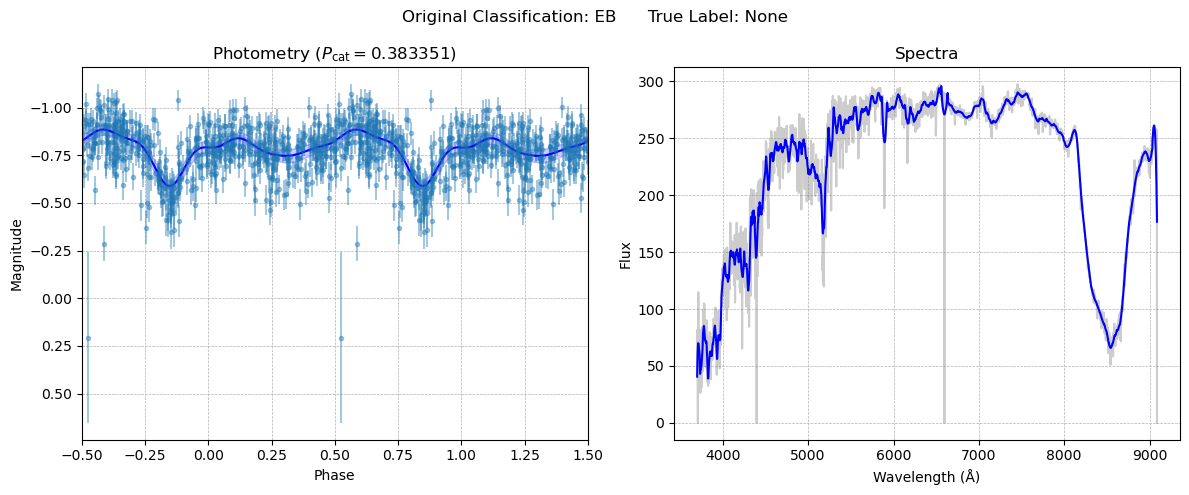

In [820]:
plot_both(test_dataset, 120)

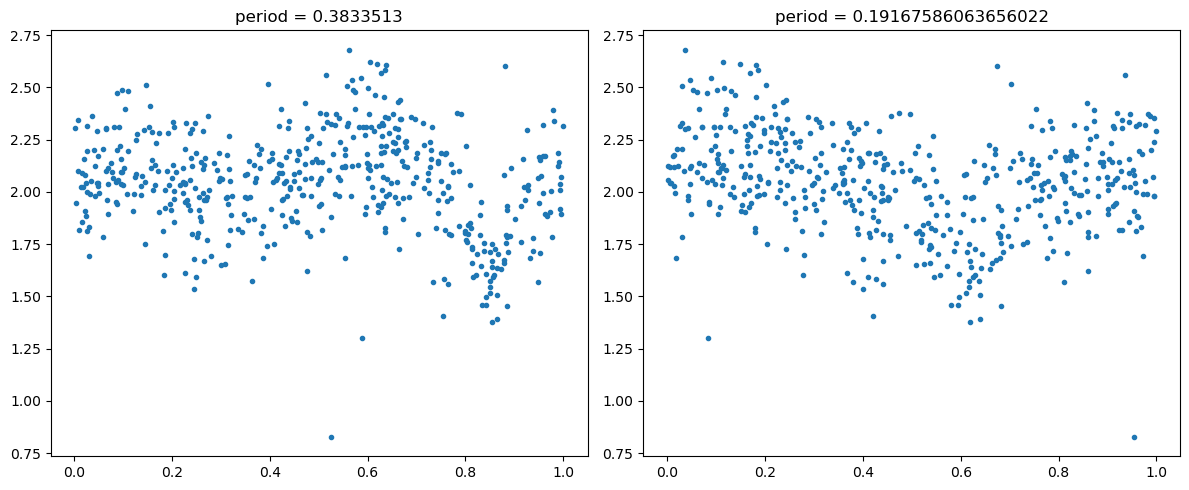

In [824]:
plot_wrong_period(test_dataset, 120)

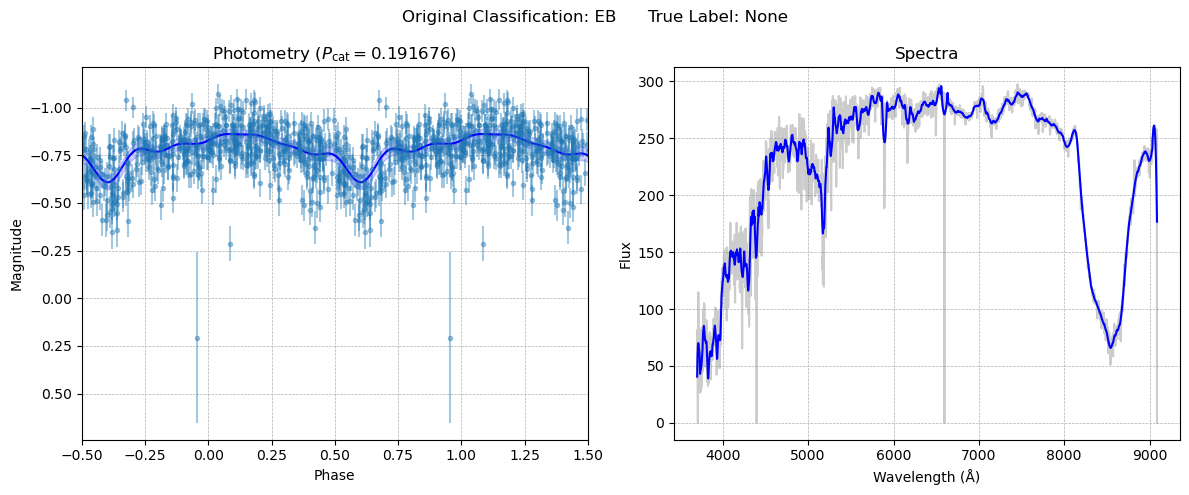

In [827]:
plot_both(test_dataset, 120, period=0.19167586062656022)

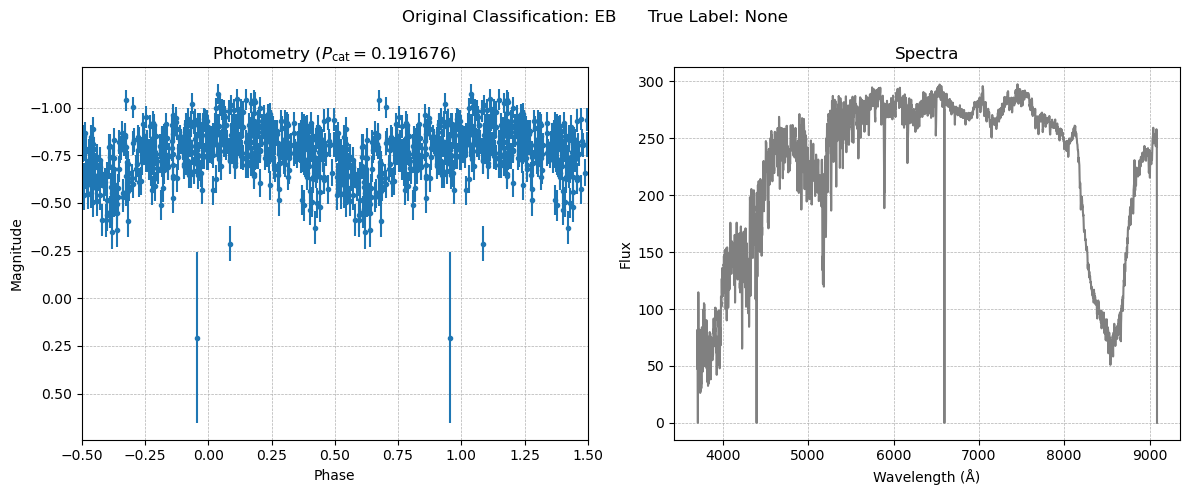

In [825]:
plot_both_no_fit(test_dataset, 120, period=0.19167586062656022)

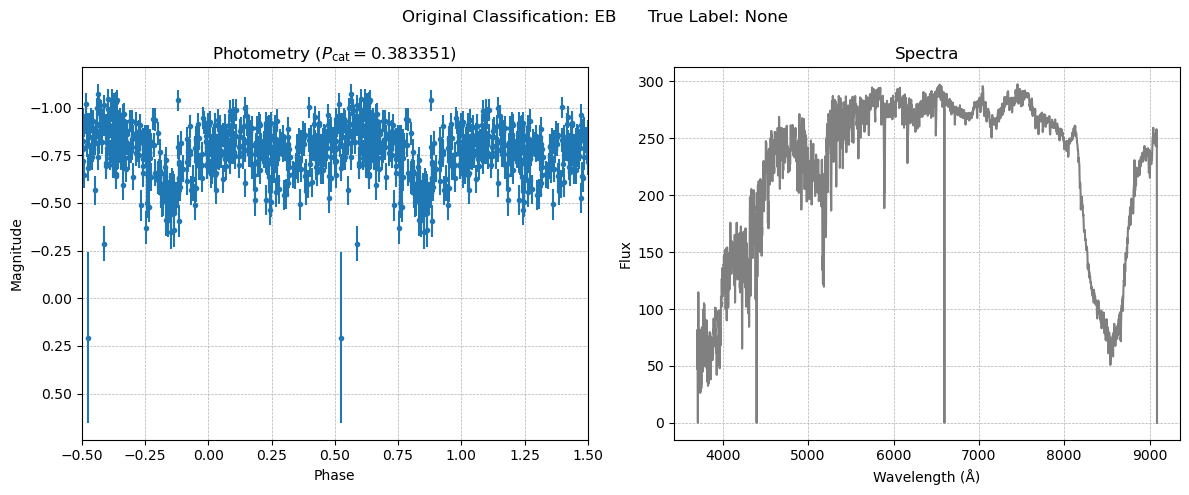

In [822]:
plot_both_no_fit(test_dataset, 120)

In [241]:
def plot_photometry2(dataset, idx, period=None):
    el = dataset.df.iloc[idx]
    label = target2id[el['target']]
    period = period if period else el['org_period']
    
    photometry = dataset.get_vlc(el['name'])
    photometry = np.vstack(((photometry[:, 0] % period) / period, photometry[:, 1], photometry[:, 2])).T    # fold
    
    plt.figure(figsize=(6, 5))
    plt.plot(photometry[:, 0], photometry[:, 1], '.', label='Photometry')
    plt.suptitle(f'period = {period}    label = {id2target[label]}')
    plt.tight_layout()
    plt.show()


def plot_photometry3(dataset, idx, period=None):
    el = dataset.df.iloc[idx]
    label = target2id[el['target']]
    period = period if period else el['org_period']
    
    photometry = dataset.get_vlc(el['name'])
    photometry = np.vstack(((photometry[:, 0] % period) / period, photometry[:, 1], photometry[:, 2])).T    # fold
    sorted_indices = np.argsort(photometry[:, 0])
    photometry = photometry[sorted_indices]
    
    phase = photometry[:, 0]
    flux = photometry[:, 1]
    flux_err = photometry[:, 2]
    
    spl = UnivariateSpline(phase, flux, s=20)  # s=1 is the smoothing factor    
    phase_pred = np.linspace(0, 1, 1000)
    flux_pred = spl(phase_pred)
    
    # Plot the spline fit
    plt.figure(figsize=(8, 6))
    plt.errorbar(phase, flux, yerr=flux_err, fmt='.', label="Photometry", color='gray', alpha=0.5)
    plt.plot(phase_pred, flux_pred, 'g-', label="Spline Fit")
    plt.xlabel("Phase (folded)")
    plt.ylabel("Flux")
    plt.title(f"period = {period}    label = {id2target[label]}")
    plt.legend()
    plt.show()

In [385]:
def plot_photometry_flux(dataset, idx, kernel=None):
    el = dataset.df.iloc[idx]
    label = target2id[el['target']]
    period = el['org_period']
    
    photometry = dataset.get_vlc(el['name'])
    time, flux, flux_err = photometry[:, 0], photometry[:, 1], photometry[:, 2]
    
    phased = (time % period) / period
    phased_i = np.argsort(phased)
    
    phase = phased[phased_i]
    flux = flux[phased_i]
    flux_err = flux_err[phased_i]
    
    flux_mean = np.mean(flux)
    flux_std = np.std(flux)
    
    X = phase.reshape(-1, 1)
    y = (flux - flux_mean) / flux_std
    
    kernel = kernel if kernel else 1.0 * RBF(length_scale=1.0)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=flux_err**2)
    gp.fit(X, y)
    
    # Generate test points to predict over (a denser time grid)
    X_test = np.linspace(0, 1, 1000).reshape(-1, 1)
    y_pred, y_std = gp.predict(X_test, return_std=True)
    X_test = X_test.ravel()
    
    # De-normalize the predicted values to original scale
    y_pred = y_pred * flux_std + flux_mean
    y_std = y_std * flux_std

    # Plot original photometry
    plt.figure(figsize=(6, 5))
    # plt.errorbar(np.hstack([phase - 0.5, phase + 0.5]), np.hstack([mag, mag]), #yerr=np.hstack([dmag, dmag]),
    #              fmt='.', label='Photometry', alpha=0.4)
    plt.errorbar(np.hstack([phase - 0.5, phase + 0.5]), np.hstack([flux, flux]), yerr=np.hstack([flux_err, flux_err]), 
                 fmt='.', label='Photometry', alpha=0.4)
    
    # Plot GP prediction with uncertainty bounds
    plt.plot(np.hstack([X_test - 0.5, X_test + 0.5]), np.hstack([y_pred, y_pred]), label='GP Fit', color='blue')
    y_minus_std = np.hstack([y_pred - y_std, y_pred - y_std])
    y_plus_std = np.hstack([y_pred + y_std, y_pred + y_std])
    plt.fill_between(np.hstack([X_test - 0.5, X_test + 0.5]), y_minus_std, y_plus_std, color='blue', alpha=0.2, label='Uncertainty')

    # Plot details
    plt.xlabel('Phase')
    plt.ylabel('Flux')
    plt.text(0.99, 0.97, f'$P_{{\\rm cat}} = {period:.6f}$', horizontalalignment='right', verticalalignment='top',
             transform=plt.gca().transAxes, fontsize=10)
    plt.title('Photometry')
    plt.legend()
    # plt.legend([f'Photometry', f'GP Fit ($P_{{\\rm cat}} = {period:.6f}$)', 'Uncertainty'])
    plt.tight_layout()
    plt.show()

In [625]:
def plot_spectra(dataset, idx, window_length=51, polyorder=3):
    el = dataset.df.iloc[idx]
    label = target2id[el['target']]
    period = el['org_period']
    
    spectra = dataset.readLRSFits(os.path.join(dataset.lamost_spec_dir, el['spec_filename']))
    smoothed_spectra = savgol_filter(spectra[:, 1], window_length=window_length, polyorder=polyorder)

    plt.figure(figsize=(6, 5))
    plt.plot(spectra[:, 0], spectra[:, 1], color='gray', alpha=0.4, label='Original Spectra')
    plt.plot(spectra[:, 0], smoothed_spectra, color='blue', linewidth=1.5, label='Smoothed Spectra')
    # plt.title(f'period = {period}    label = {id2target[label]}')
    plt.xlabel('Wavelength (Å)')
    plt.ylabel('Flux')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.title('Spectra')
    plt.tight_layout()
    # plt.legend()
    plt.show()

In [639]:
def plot_photometry_flux(dataset, idx):
    el = dataset.df.iloc[idx]
    label = target2id[el['target']]
    period = el['org_period']
    
    photometry = dataset.get_vlc(el['name'])
    flux_time, flux, flux_err = photometry[:, 0], photometry[:, 1], photometry[:, 2]
    
    phased = (flux_time % period) / period
    phased_i = np.argsort(phased)
    
    phase = phased[phased_i]
    flux = flux[phased_i]
    flux_err = flux_err[phased_i]
    
    mag = -2.5 * np.log10(flux)
    dmag = (2.5 / np.log(10)) * (flux_err / flux)
    time = np.linspace(0, 1, 1000)

    phase3 = np.hstack([phase - 1, phase, phase + 1])
    mag3 = np.hstack([mag, mag, mag])
    dmag3 = np.hstack([dmag, dmag, dmag])
    time3 = np.hstack([time - 1, time, time + 1])

    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(0.1, (1e-2, 1e2))
    # gp = GaussianProcessRegressor(kernel=kernel, alpha=dmag ** 2, n_restarts_optimizer=10)
    # gp.fit(phase.reshape(-1, 1), mag)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=dmag3 ** 2, n_restarts_optimizer=10)
    gp.fit(phase3.reshape(-1, 1), mag3)

    # y_fit, sigma = gp.predict(time.reshape(-1, 1), return_std=True)
    y_fit, sigma = gp.predict(time3.reshape(-1, 1), return_std=True)

    plt.figure(figsize=(6, 5))
    
    # y_fit3 = np.hstack([y_fit, y_fit, y_fit])
    # sigma3 = np.hstack([sigma, sigma, sigma])

    plt.errorbar(phase3, mag3, yerr=dmag3, fmt='.', label='Photometry', alpha=0.4)
    plt.plot(time3, y_fit, label='GP Fit', color='blue')
    plt.fill_between(time3, y_fit - 3 * sigma, y_fit + 3 * sigma, alpha=0.2, color='blue', label='Uncertainty')
    plt.xlim(-0.5, 1.5)

    # plt.errorbar(phase, mag, yerr=dmag, fmt='.', label='Photometry', alpha=0.4)
    # plt.plot(time, y_fit, label='GP Fit', color='blue')
    # plt.fill_between(time, y_fit - 3 * sigma, y_fit + 3 * sigma, alpha=0.2, color='blue', label='Uncertainty')
    
    plt.xlabel('Phase')
    plt.ylabel('Magnitude')
    # plt.text(0.24, 0.98, f'$P_{{\\rm cat}} = {period:.6f}$', horizontalalignment='right', verticalalignment='top',
    #          transform=plt.gca().transAxes, fontsize=10)
    plt.title(f'Photometry ($P_{{\\rm cat}} = {period:.6f}$)')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    # plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

In [823]:
def plot_both_no_fit(dataset, idx, true_label=None, noise_level=0.0, period=None):
    el = dataset.df.iloc[idx]
    label = target2id[el['target']]
    period = period if period else el['org_period']

    # Photometry
    photometry = dataset.get_vlc(el['name'])
    flux_time, flux, flux_err = photometry[:, 0], photometry[:, 1], photometry[:, 2]
    
    phased = (flux_time % period) / period
    phased_i = np.argsort(phased)
    
    phase = phased[phased_i]
    flux = flux[phased_i]
    flux_err = flux_err[phased_i]
    
    mag = -2.5 * np.log10(flux)
    dmag = (2.5 / np.log(10)) * (flux_err / flux)
    time = np.linspace(0, 1, 1000)

    phase3 = np.hstack([phase - 1, phase, phase + 1])
    mag3 = np.hstack([mag, mag, mag])
    dmag3 = np.hstack([dmag, dmag, dmag])
    time3 = np.hstack([time - 1, time, time + 1])

    # kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(0.1, (1e-2, 1e2))
    # gp = GaussianProcessRegressor(kernel=kernel, alpha=dmag3 ** 2 + noise_level, n_restarts_optimizer=20)
    # gp.fit(phase3.reshape(-1, 1), mag3)

    # y_fit, sigma = gp.predict(time3.reshape(-1, 1), return_std=True)
    
    # Spectra
    spectra = dataset.readLRSFits(os.path.join(dataset.lamost_spec_dir, el['spec_filename']))
    # smoothed_spectra = savgol_filter(spectra[:, 1], window_length=51, polyorder=3)

    # Plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  
    
    ax1.errorbar(phase3, mag3, yerr=dmag3, fmt='.', label='Photometry')
    # ax1.plot(time3, y_fit, label='GP Fit', color='blue')
    # ax1.fill_between(time3, y_fit - 3 * sigma, y_fit + 3 * sigma, alpha=0.2, color='blue', label='Uncertainty')
    ax1.set_xlim(-0.5, 1.5)    
    ax1.set_xlabel('Phase')
    ax1.set_ylabel('Magnitude')
    ax1.set_title(f'Photometry ($P_{{\\rm cat}} = {period:.6f}$)')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax1.invert_yaxis()

    ax2.plot(spectra[:, 0], spectra[:, 1], color='gray', label='Original Spectra')
    # ax2.plot(spectra[:, 0], smoothed_spectra, color='blue', linewidth=1.5, label='Smoothed Spectra')
    ax2.set_xlabel('Wavelength (Å)')
    ax2.set_ylabel('Flux')
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax2.set_title('Spectra')

    plt.suptitle(f"Original Classification: {el['target']}      True Label: {true_label}")
    plt.tight_layout()
    plt.show()

In [831]:
def plot_both(dataset, idx, true_label=None, noise_level=0.0, period=None):
    el = dataset.df.iloc[idx]
    label = target2id[el['target']]
    period = period if period else el['org_period']

    # Photometry
    photometry = dataset.get_vlc(el['name'])
    flux_time, flux, flux_err = photometry[:, 0], photometry[:, 1], photometry[:, 2]
    
    phased = (flux_time % period) / period
    phased_i = np.argsort(phased)
    
    phase = phased[phased_i]
    flux = flux[phased_i]
    flux_err = flux_err[phased_i]
    
    mag = -2.5 * np.log10(flux)
    dmag = (2.5 / np.log(10)) * (flux_err / flux)
    time = np.linspace(0, 1, 1000)

    phase3 = np.hstack([phase - 1, phase, phase + 1])
    mag3 = np.hstack([mag, mag, mag])
    dmag3 = np.hstack([dmag, dmag, dmag])
    time3 = np.hstack([time - 1, time, time + 1])

    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(0.1, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=dmag3 ** 2 + noise_level, n_restarts_optimizer=20)
    gp.fit(phase3.reshape(-1, 1), mag3)

    y_fit, sigma = gp.predict(time3.reshape(-1, 1), return_std=True)
    
    # Spectra
    spectra = dataset.readLRSFits(os.path.join(dataset.lamost_spec_dir, el['spec_filename']))
    smoothed_spectra = savgol_filter(spectra[:, 1], window_length=51, polyorder=3)

    # Plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  
    
    ax1.errorbar(phase3, mag3, yerr=dmag3, fmt='.', label='Photometry', alpha=0.4)
    ax1.plot(time3, y_fit, label='GP Fit', color='blue')
    ax1.fill_between(time3, y_fit - 3 * sigma, y_fit + 3 * sigma, alpha=0.2, color='blue', label='Uncertainty')
    ax1.set_xlim(-0.5, 1.5)    
    ax1.set_xlabel('Phase')
    ax1.set_ylabel('Magnitude')
    ax1.set_title(f'Photometry ($P_{{\\rm cat}} = {period:.6f}$)')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax1.invert_yaxis()

    ax2.plot(spectra[:, 0], spectra[:, 1], color='gray', alpha=0.4, label='Original Spectra')
    ax2.plot(spectra[:, 0], smoothed_spectra, color='blue', linewidth=1.5, label='Smoothed Spectra')
    ax2.set_xlabel('Wavelength (Å)')
    ax2.set_ylabel('Flux')
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax2.set_title('Spectra')

    if true_label:
        plt.suptitle(f"Original Classification: {el['target']}      True Label: {true_label}")
    else:
        plt.suptitle(f"Original Classification: {el['target']}")
        
    plt.tight_layout()
    plt.show()

In [814]:
test_dataset.df.iloc[120]

mean_vmag                                                    1.822404
amplitude                                                   -0.080925
period                                                      -0.735583
phot_g_mean_mag                                               1.65485
e_phot_g_mean_mag                                           -0.499512
lksl_statistic                                               0.952875
rfr_score                                                   -1.132625
phot_bp_mean_mag                                             1.790759
e_phot_bp_mean_mag                                          -0.315967
phot_rp_mean_mag                                             1.538431
e_phot_rp_mean_mag                                           -0.51058
bp_rp                                                       -0.089744
parallax                                                     0.580568
parallax_error                                              -0.172781
parallax_over_error 

In [792]:
train_dataset.df.iloc[472]['name']

'ASASSN-VJ233803.41+524738.8'

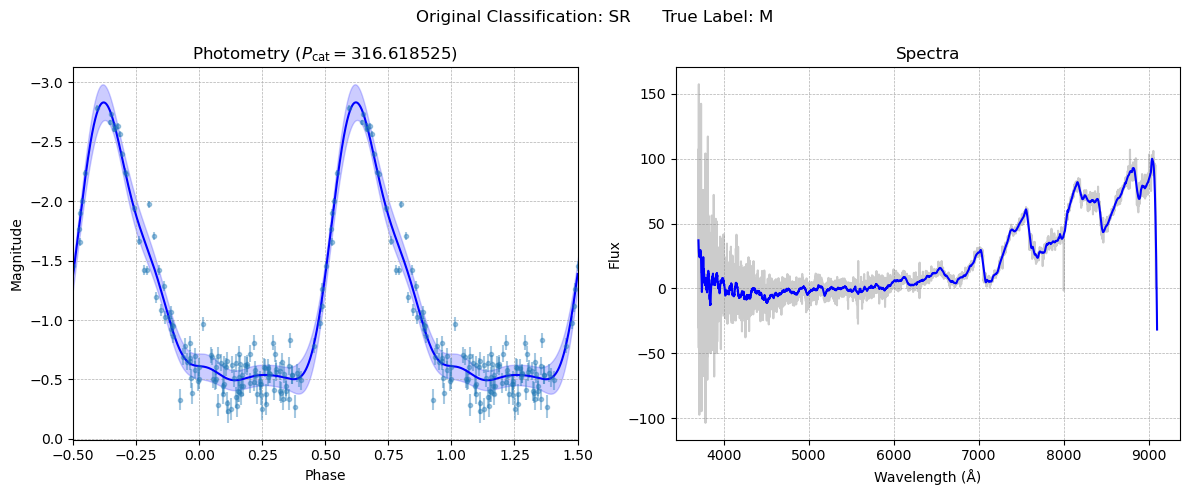

In [809]:
plot_both(train_dataset, 472, 'M', noise_level=0.01)

In [791]:
train_dataset.df.iloc[403]['name']

'ASASSN-VJ072950.12+103655.8'

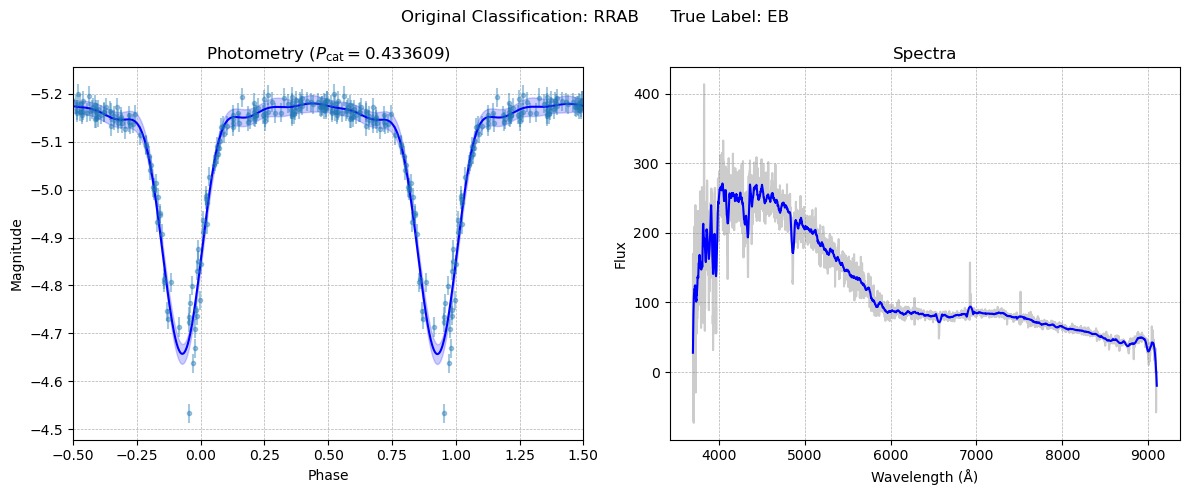

In [828]:
plot_both(train_dataset, 403, 'EB')

In [790]:
train_dataset.df.iloc[488]['name']

'ASASSN-VJ043834.37+205330.0'

/global/home/users/mariia/miniforge3/envs/astro/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


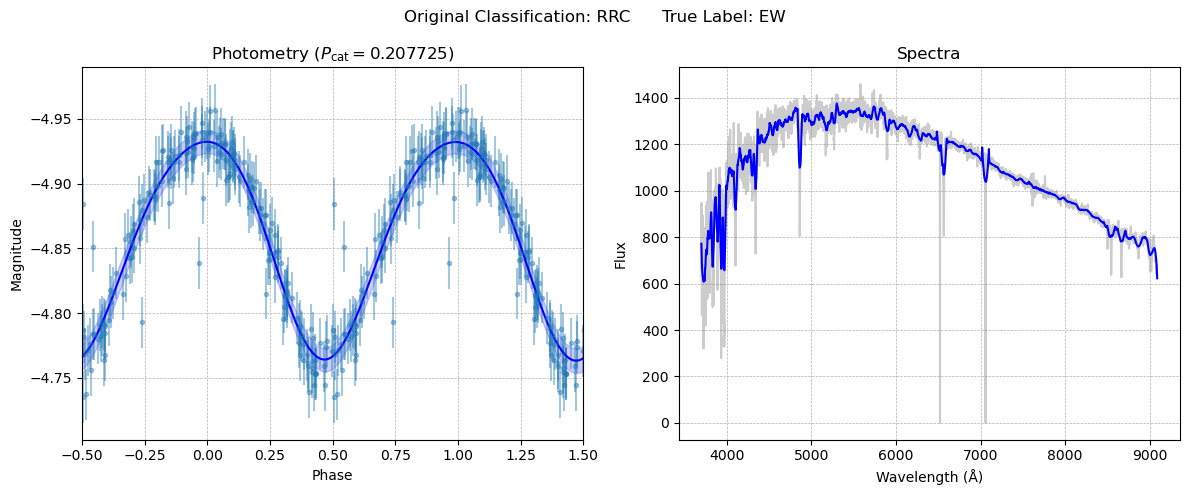

In [810]:
plot_both(train_dataset, 488, 'EW')

In [789]:
train_dataset.df.iloc[898]['name']

'ASASSN-VJ053427.84-054137.8'

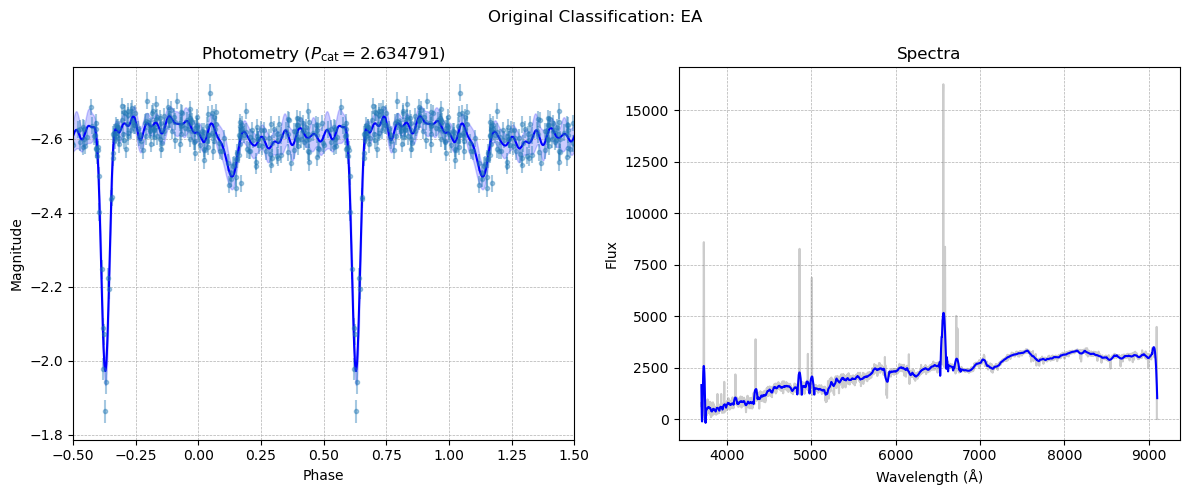

In [832]:
# https://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2004ApJS..151..357S
# written about by our colaborator
plot_both(train_dataset, 898)

In [788]:
train_dataset.df.iloc[1093]['name']

'ASASSN-VJ102927.87+564754.3'

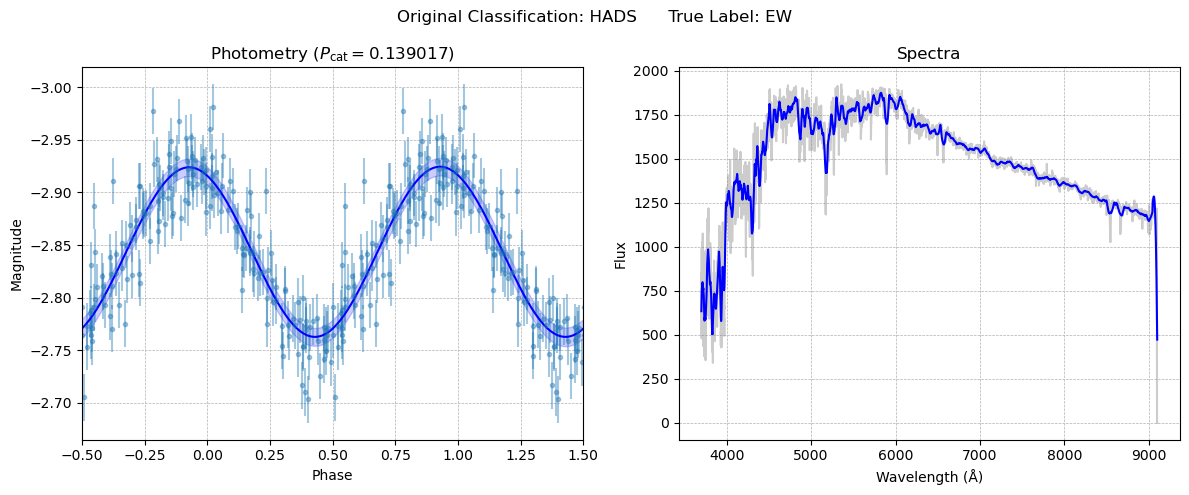

In [812]:
plot_both(train_dataset, 1093, 'EW')

In [793]:
train_dataset.df.iloc[1159]['name']

'ASASSN-VJ044945.25+184821.2'

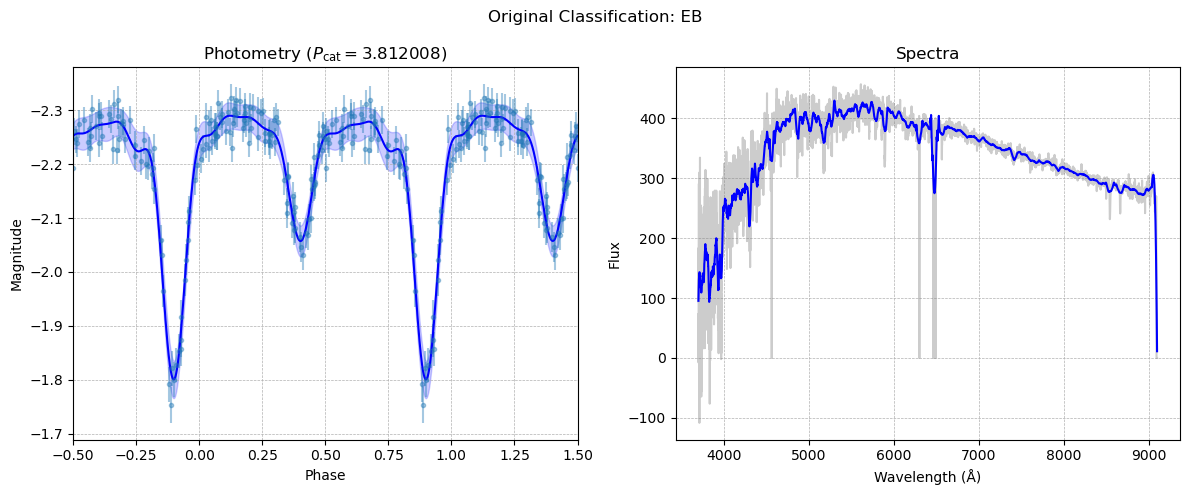

In [833]:
plot_both(train_dataset, 1159)

In [795]:
train_dataset.df.iloc[1235]['name']

'ASASSN-VJ062640.03+184212.6'

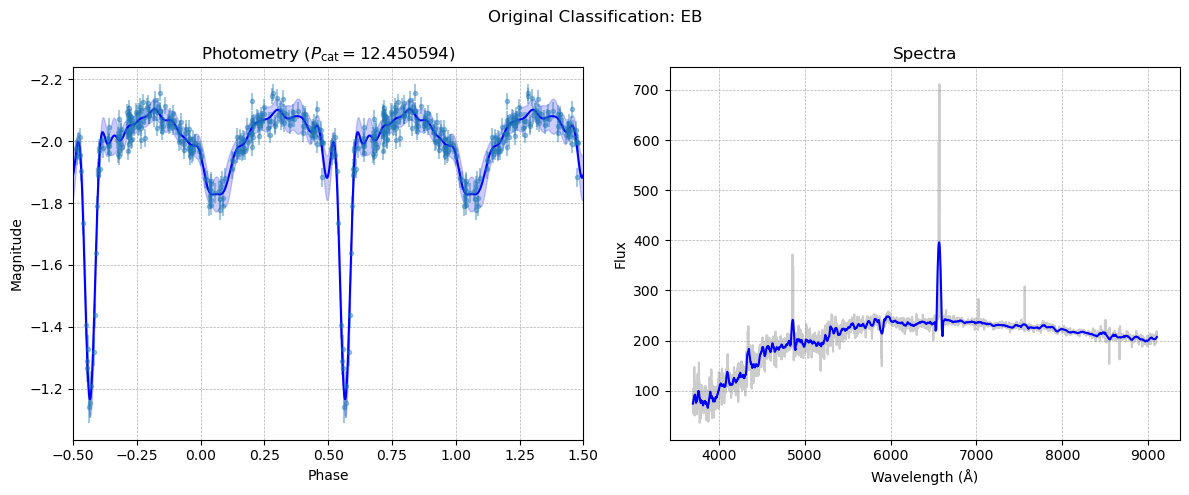

In [834]:
# interesting star, nothing written about it
# it’s a semi-detacted binary with emission lines
plot_both(train_dataset, 1235) #, 'Correctly classified but because of the emission lines was marked as outlier', noise_level=0.001)

In [796]:
train_dataset.df.iloc[4414]['name']

'ASASSN-VJ042454.47+492614.2'

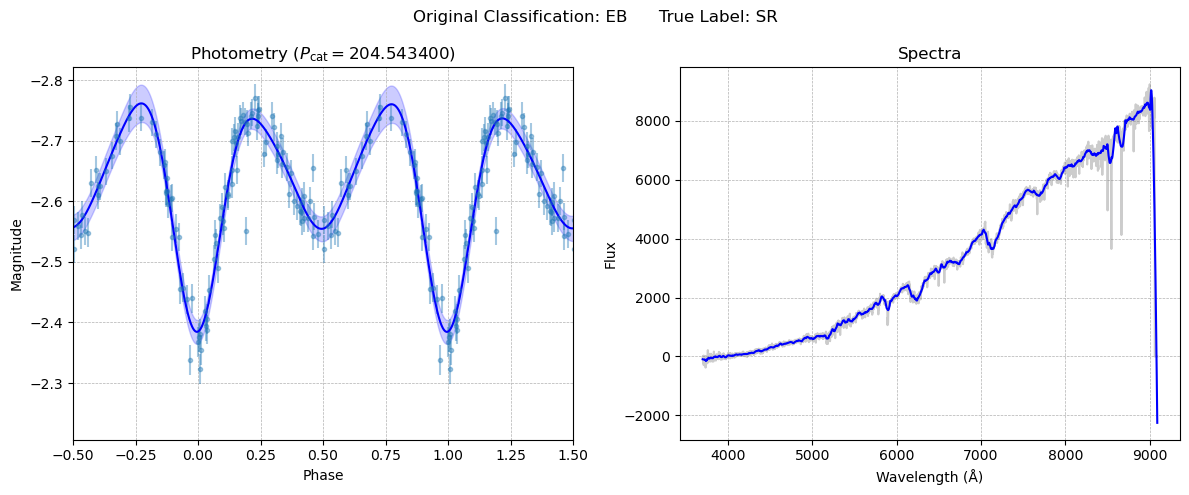

In [813]:
# interesting
plot_both(train_dataset, 4414, 'SR')

In [797]:
train_dataset.df.iloc[6265]['name']

'ASASSN-VJ041806.15+165653.6'

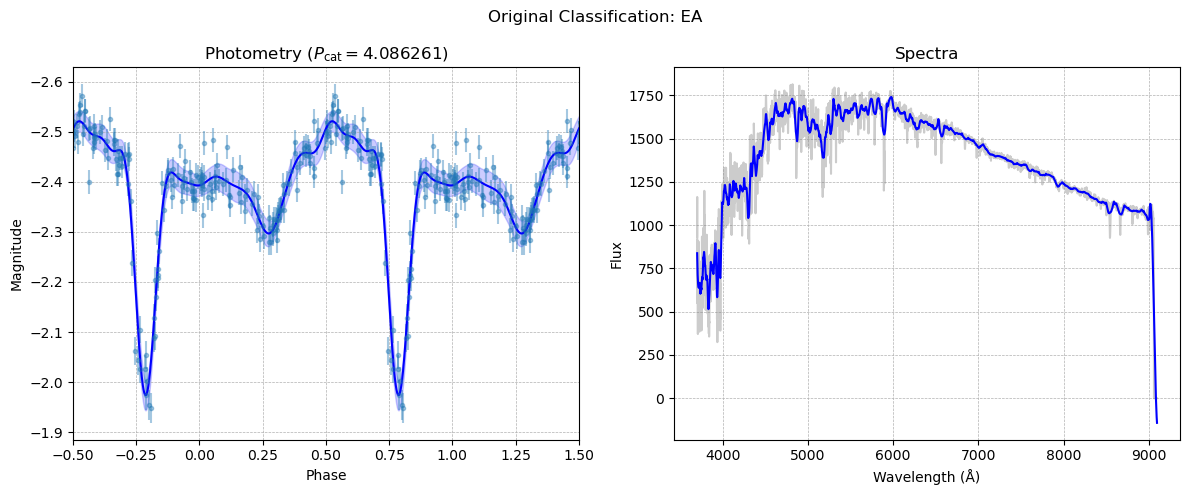

In [835]:
# interesting
plot_both(train_dataset, 6265)

In [799]:
train_dataset.df.iloc[7218]['name']

'ASASSN-VJ191702.64+421121.1'

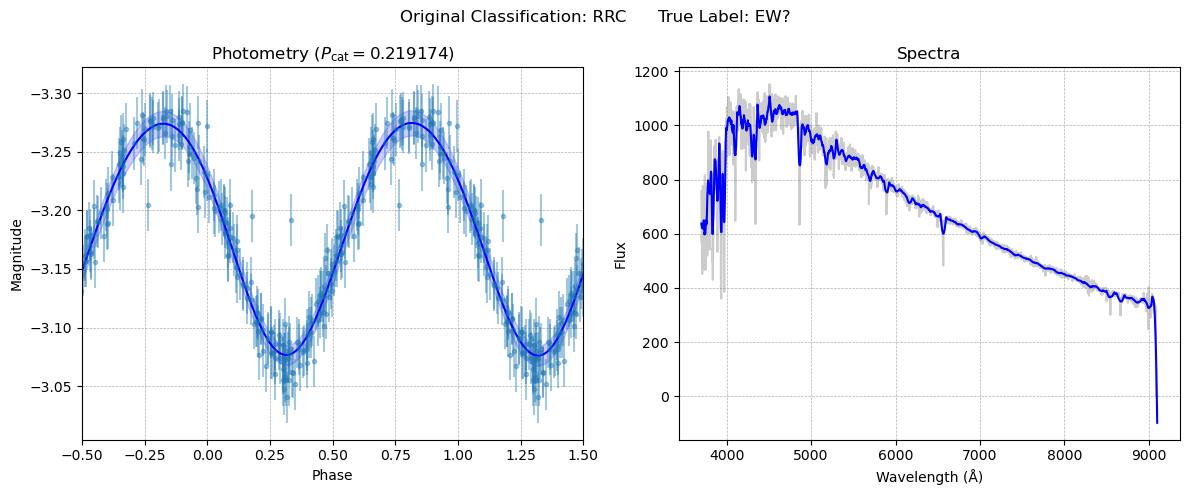

In [778]:
plot_both(train_dataset, 7218, 'EW?')

In [643]:
train_dataset.df.iloc[4396]

mean_vmag                                                   -1.600342
amplitude                                                   -0.337755
period                                                      -0.345456
phot_g_mean_mag                                              -1.62895
e_phot_g_mean_mag                                           -0.376928
lksl_statistic                                               1.357988
rfr_score                                                    -1.42182
phot_bp_mean_mag                                            -1.565797
e_phot_bp_mean_mag                                          -0.113929
phot_rp_mean_mag                                             -1.68392
e_phot_rp_mean_mag                                          -0.469465
bp_rp                                                        0.963241
parallax                                                    -0.440679
parallax_error                                              -0.397891
parallax_over_error 

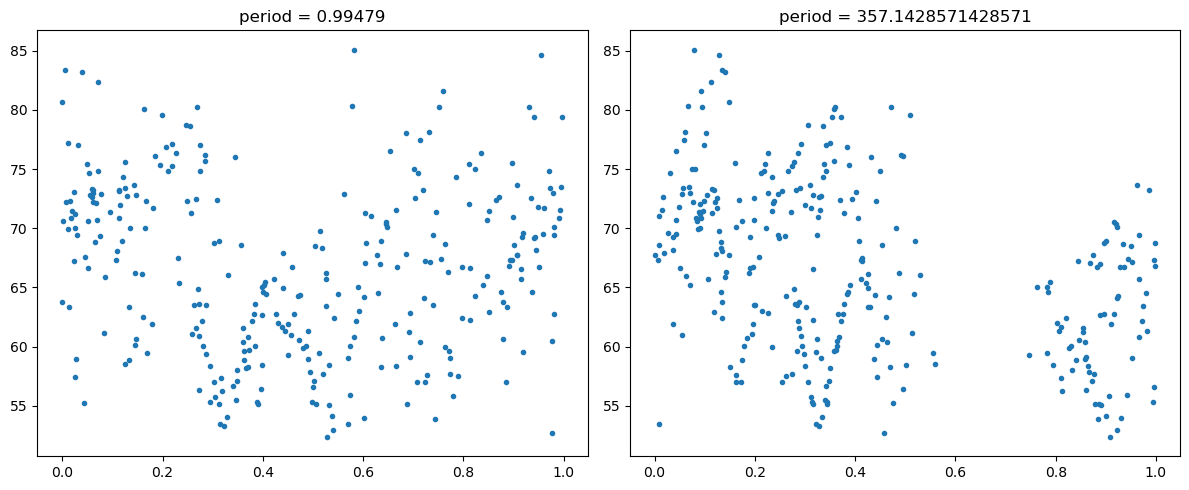

In [644]:
plot_wrong_period(train_dataset, 4396)

/global/home/users/mariia/miniforge3/envs/astro/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


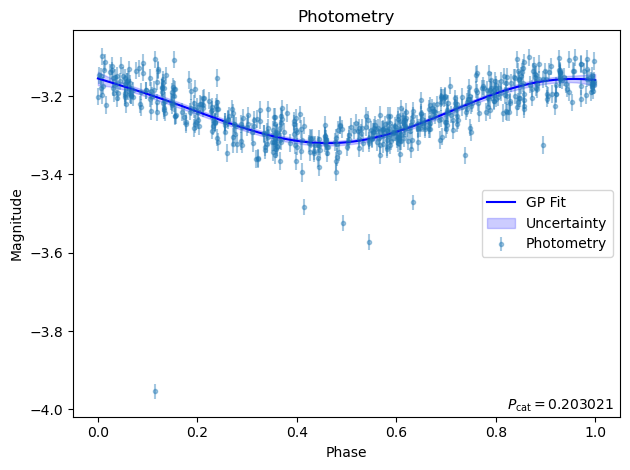

In [576]:
plot_photometry_flux(val_dataset, 84)

<ErrorbarContainer object of 3 artists>

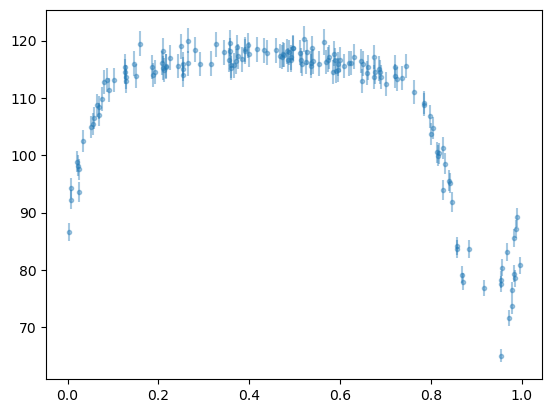

In [440]:
# plt.errorbar(np.hstack([phase - 0.5, phase + 0.5]), np.hstack([flux, flux]), yerr=np.hstack([flux_err, flux_err]), 
#              fmt='.', label='Photometry', alpha=0.4)
plt.errorbar(phase, flux, yerr=flux_err, fmt='.', label='Photometry', alpha=0.4)

<ErrorbarContainer object of 3 artists>

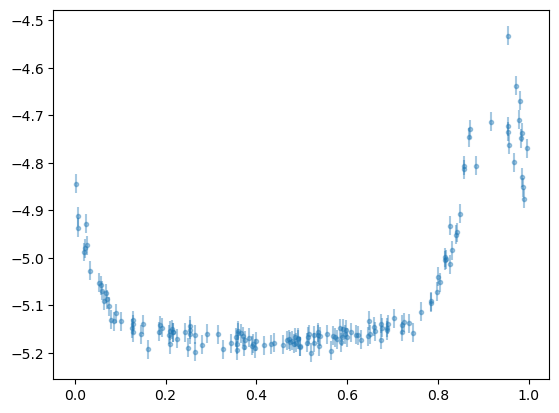

In [441]:
# plt.errorbar(np.hstack([phase - 0.5, phase + 0.5]), np.hstack([mag, mag]), yerr=np.hstack([dmag, dmag]),
#              fmt='.', label='Photometry', alpha=0.4)
plt.errorbar(phase, mag, yerr=dmag, fmt='.', label='Photometry', alpha=0.4)

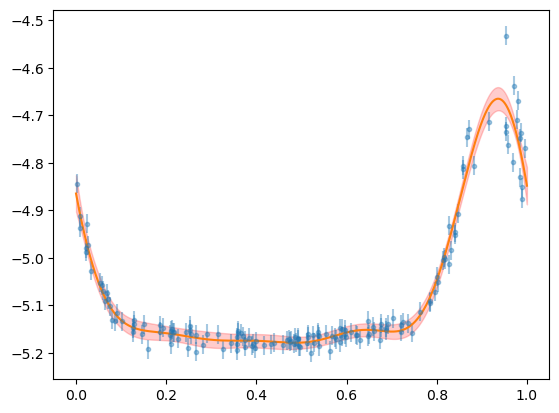

In [554]:
time = np.linspace(0, 1, 1000)

# ls = LombScargle(phase, mag, dmag, nterms=8)
# y_fit = ls.model(time, 1 / period)

# coeffs = np.polyfit(phase, mag, 16)
# poly = np.poly1d(coeffs)
# y_fit = poly(time)

kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(0.1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, alpha=dmag ** 2, n_restarts_optimizer=10)
gp.fit(phase.reshape(-1, 1), mag)
y_fit, sigma = gp.predict(time.reshape(-1, 1), return_std=True)

plt.errorbar(phase, mag, yerr=dmag, fmt='.', label='Photometry', alpha=0.4)
plt.plot(time, y_fit)
plt.fill_between(time, y_fit - 3 * sigma, y_fit + 3 * sigma, alpha=0.2, color='r', label='Uncertainty')

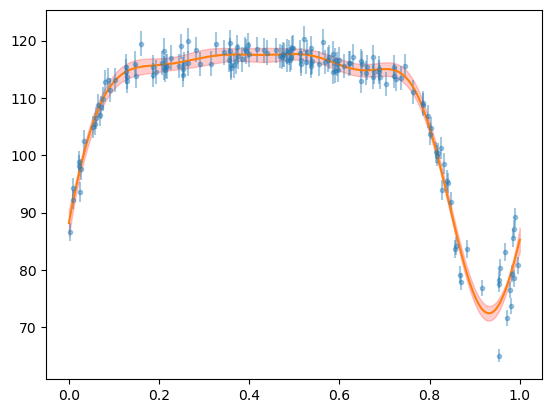

In [553]:
time = np.linspace(0, 1, 1000)

kernel = ConstantKernel(1.0, (1e-3, 1e4)) * RBF(0.1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, alpha=(0.7 * flux_err) ** 2, n_restarts_optimizer=10)
gp.fit(phase.reshape(-1, 1), flux)
y_fit, sigma = gp.predict(time.reshape(-1, 1), return_std=True)

plt.errorbar(phase, flux, yerr=flux_err, fmt='.', label='Photometry', alpha=0.4)
plt.plot(time, y_fit)
plt.fill_between(time, y_fit - 3 * sigma, y_fit + 3 * sigma, alpha=0.2, color='r', label='Uncertainty')

<ErrorbarContainer object of 3 artists>

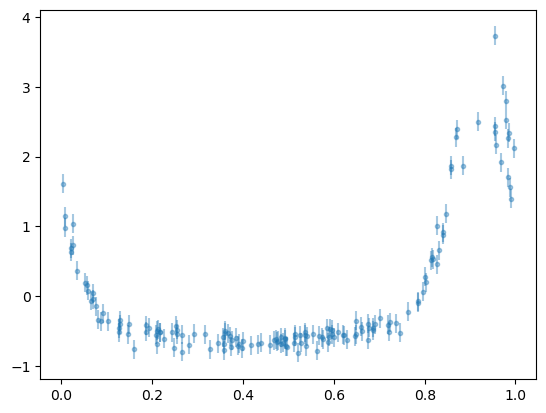

In [526]:
plt.errorbar(phase, mag_norm, yerr=dmag_norm, fmt='.', label='Photometry', alpha=0.4)

In [518]:
sigma[:10]

array([7.90779626e-07, 7.67982385e-07, 7.45876811e-07, 7.24446914e-07,
       7.03691487e-07, 6.83614183e-07, 6.64206214e-07, 6.45455635e-07,
       6.27390862e-07, 6.09972750e-07])

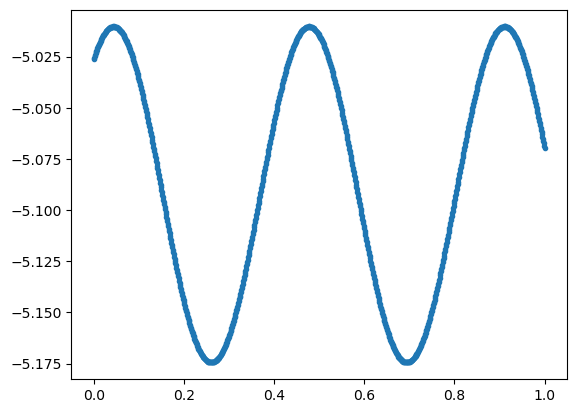

In [445]:
plt.plot(time, y_fit, '.')
# plt.errorbar(np.hstack([time - 0.5, time + 0.5]), np.hstack([y_fit, y_fit]),
#              fmt='.', label='Photometry', alpha=0.4)

In [ ]:

mag_mean = np.mean(mag)
mag_std = np.std(mag)

# flux_mean = np.mean(flux)
# flux_std = np.std(flux)

X = phase.reshape(-1, 1)
y = (mag - mag_mean) / mag_std
# y = (flux - flux_mean) / flux_std

kernel = kernel if kernel else 1.0 * RBF(length_scale=1.0)
gp = GaussianProcessRegressor(kernel=kernel, alpha=dmag**2)
# gp = GaussianProcessRegressor(kernel=kernel, alpha=flux_err**2)
gp.fit(X, y)

# Generate test points to predict over (a denser time grid)
X_test = np.linspace(0, 1, 1000).reshape(-1, 1)
y_pred, y_std = gp.predict(X_test, return_std=True)
X_test = X_test.ravel()

# De-normalize the predicted values to original scale
y_pred = y_pred * mag_std + mag_mean
y_std = y_std * mag_std
# y_pred = y_pred * flux_std + flux_mean
# y_std = y_std * flux_std

# Plot original photometry
plt.figure(figsize=(6, 5))
plt.errorbar(np.hstack([phase - 0.5, phase + 0.5]), np.hstack([mag, mag]), #yerr=np.hstack([dmag, dmag]),
             fmt='.', label='Photometry', alpha=0.4)
# plt.errorbar(phase, flux, yerr=flux_err, fmt='.', label='Photometry', alpha=0.4)

# Plot GP prediction with uncertainty bounds
plt.plot(np.hstack([X_test - 0.5, X_test + 0.5]), np.hstack([y_pred, y_pred]), label='GP Fit', color='blue')
y_minus_std = np.hstack([y_pred - y_std, y_pred - y_std])
y_plus_std = np.hstack([y_pred + y_std, y_pred + y_std])
plt.fill_between(np.hstack([X_test - 0.5, X_test + 0.5]), y_minus_std, y_plus_std, color='blue', alpha=0.2, label='Uncertainty')

# Plot details
plt.xlabel('Phase')
plt.ylabel('Magnitude')
# plt.ylabel('Flux')
plt.text(0.99, 0.04, f'$P_{{\\rm cat}} = {period:.6f}$', horizontalalignment='right', verticalalignment='top',
         transform=plt.gca().transAxes, fontsize=10)
plt.title('Photometry')
plt.legend()
# plt.legend([f'Photometry', f'GP Fit ($P_{{\\rm cat}} = {period:.6f}$)', 'Uncertainty'])
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

In [ ]:
    el = dataset.df.iloc[idx]
    label = target2id[el['target']]
    period = el['org_period']
    
    photometry = dataset.get_vlc(el['name'])
    time, flux, flux_err = photometry[:, 0], photometry[:, 1], photometry[:, 2]
    
    phased = (time % period) / period
    phased_i = np.argsort(phased)
    
    phase = phased[phased_i]
    flux = flux[phased_i]
    flux_err = flux_err[phased_i]
    
    flux_mean = np.mean(flux)
    flux_std = np.std(flux)
    
    X = phase.reshape(-1, 1)
    y = (flux - flux_mean) / flux_std
    
    kernel = kernel if kernel else 1.0 * RBF(length_scale=1.0)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=flux_err**2)
    gp.fit(X, y)
    
    # Generate test points to predict over (a denser time grid)
    X_test = np.linspace(0, 1, 1000).reshape(-1, 1)
    y_pred, y_std = gp.predict(X_test, return_std=True)
    X_test = X_test.ravel()
    
    # De-normalize the predicted values to original scale
    y_pred = y_pred * flux_std + flux_mean
    y_std = y_std * flux_std

    # Plot original photometry
    plt.figure(figsize=(6, 5))
    # plt.errorbar(np.hstack([phase - 0.5, phase + 0.5]), np.hstack([mag, mag]), #yerr=np.hstack([dmag, dmag]),
    #              fmt='.', label='Photometry', alpha=0.4)
    plt.errorbar(np.hstack([phase - 0.5, phase + 0.5]), np.hstack([flux, flux]), yerr=np.hstack([flux_err, flux_err]), 
                 fmt='.', label='Photometry', alpha=0.4)
    
    # Plot GP prediction with uncertainty bounds
    plt.plot(np.hstack([X_test - 0.5, X_test + 0.5]), np.hstack([y_pred, y_pred]), label='GP Fit', color='blue')
    y_minus_std = np.hstack([y_pred - y_std, y_pred - y_std])
    y_plus_std = np.hstack([y_pred + y_std, y_pred + y_std])
    plt.fill_between(np.hstack([X_test - 0.5, X_test + 0.5]), y_minus_std, y_plus_std, color='blue', alpha=0.2, label='Uncertainty')

    # Plot details
    plt.xlabel('Phase')
    plt.ylabel('Flux')
    plt.text(0.99, 0.97, f'$P_{{\\rm cat}} = {period:.6f}$', horizontalalignment='right', verticalalignment='top',
             transform=plt.gca().transAxes, fontsize=10)
    plt.title('Photometry')
    plt.legend()
    # plt.legend([f'Photometry', f'GP Fit ($P_{{\\rm cat}} = {period:.6f}$)', 'Uncertainty'])
    plt.tight_layout()
    plt.show()

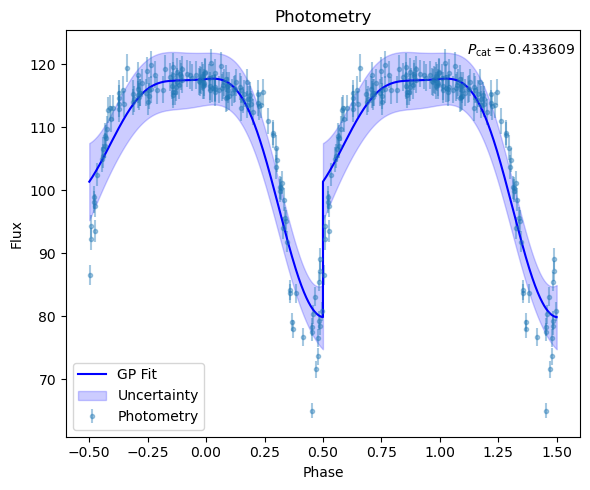

In [409]:
plot_photometry_flux(train_dataset, 403)

In [ ]:
    el = dataset.df.iloc[idx]
    label = target2id[el['target']]
    period = el['org_period']
    
    photometry = dataset.get_vlc(el['name'])
    time, flux, flux_err = photometry[:, 0], photometry[:, 1], photometry[:, 2]
    
    phased = (time % period) / period
    phased_i = np.argsort(phased)
    
    phase = phased[phased_i]
    flux = flux[phased_i]
    flux_err = flux_err[phased_i]

    mag = -2.5 * np.log10(flux)
    # dmag = 2.5 / np.log(10) * flux_err
    dmag = 2.5 * np.log10(flux_err)

    mag_mean = np.mean(mag)
    mag_std = np.std(mag)
    
    # flux_mean = np.mean(flux)
    # flux_std = np.std(flux)
    
    X = phase.reshape(-1, 1)
    y = (mag - mag_mean) / mag_std
    # y = (flux - flux_mean) / flux_std
    
    kernel = kernel if kernel else 1.0 * RBF(length_scale=1.0)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=dmag**2)
    # gp = GaussianProcessRegressor(kernel=kernel, alpha=flux_err**2)
    gp.fit(X, y)
    
    # Generate test points to predict over (a denser time grid)
    X_test = np.linspace(0, 1, 1000).reshape(-1, 1)
    y_pred, y_std = gp.predict(X_test, return_std=True)
    X_test = X_test.ravel()
    
    # De-normalize the predicted values to original scale
    y_pred = y_pred * mag_std + mag_mean
    y_std = y_std * mag_std
    # y_pred = y_pred * flux_std + flux_mean
    # y_std = y_std * flux_std

    # Plot original photometry
    plt.figure(figsize=(6, 5))
    plt.errorbar(np.hstack([phase - 0.5, phase + 0.5]), np.hstack([mag, mag]), #yerr=np.hstack([dmag, dmag]),
                 fmt='.', label='Photometry', alpha=0.4)
    # plt.errorbar(phase, flux, yerr=flux_err, fmt='.', label='Photometry', alpha=0.4)
    
    # Plot GP prediction with uncertainty bounds
    plt.plot(np.hstack([X_test - 0.5, X_test + 0.5]), np.hstack([y_pred, y_pred]), label='GP Fit', color='blue')
    y_minus_std = np.hstack([y_pred - y_std, y_pred - y_std])
    y_plus_std = np.hstack([y_pred + y_std, y_pred + y_std])
    plt.fill_between(np.hstack([X_test - 0.5, X_test + 0.5]), y_minus_std, y_plus_std, color='blue', alpha=0.2, label='Uncertainty')

    # Plot details
    plt.xlabel('Phase')
    plt.ylabel('Magnitude')
    # plt.ylabel('Flux')
    plt.text(0.99, 0.04, f'$P_{{\\rm cat}} = {period:.6f}$', horizontalalignment='right', verticalalignment='top',
             transform=plt.gca().transAxes, fontsize=10)
    plt.title('Photometry')
    plt.legend()
    # plt.legend([f'Photometry', f'GP Fit ($P_{{\\rm cat}} = {period:.6f}$)', 'Uncertainty'])
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.show()

In [302]:
idx = 403
dataset = train_dataset

el = dataset.df.iloc[idx]
label = target2id[el['target']]
period = el['org_period']

photometry = dataset.get_vlc(el['name'])
time, flux, flux_err = photometry[:, 0], photometry[:, 1], photometry[:, 2]

phased = (time % period) / period
phased_i = np.argsort(phased)

phase = phased[phased_i]
flux = flux[phased_i]
flux_err = flux_err[phased_i]

mag = -2.5 * np.log10(flux)
dmag = 2.5 / np.log(10) * flux_err

mag_mean = np.mean(mag)
mag_std = np.std(mag)

flux_mean = np.mean(flux)
flux_std = np.std(flux)

X = phase.reshape(-1, 1)
y_mag = (mag - mag_mean) / mag_std
y_flux = (flux - flux_mean) / flux_std

<ErrorbarContainer object of 3 artists>

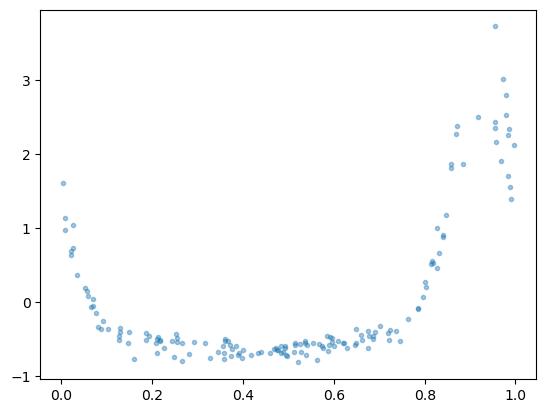

In [308]:
plt.errorbar(phase, y_mag, fmt='.', label='Photometry', alpha=0.4)

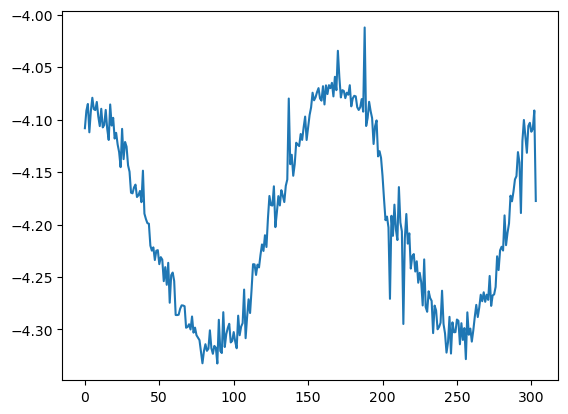

In [300]:
plt.plot(mag)

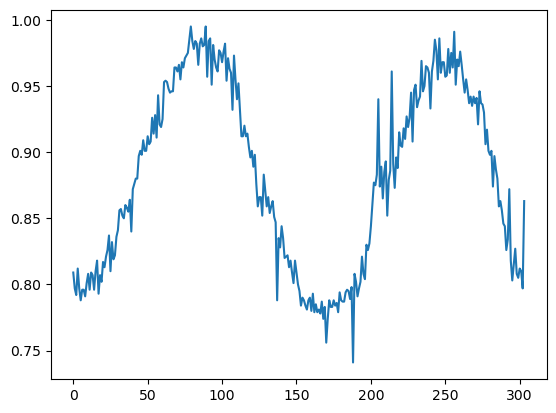

In [297]:
plt.plot(flux_err)

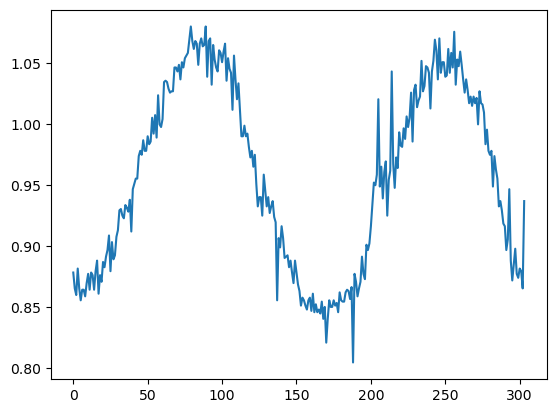

In [298]:
plt.plot(dmag)

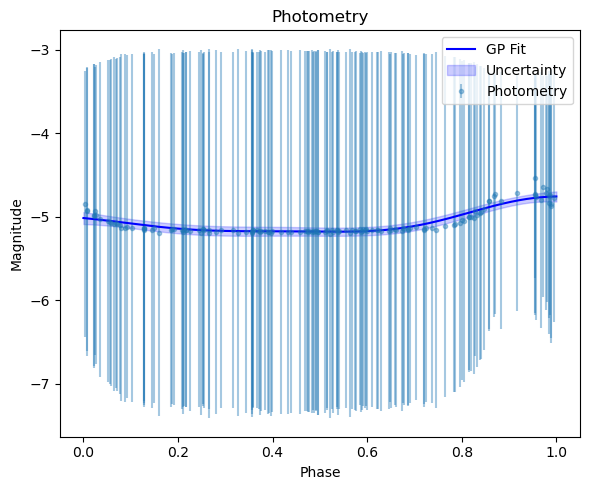

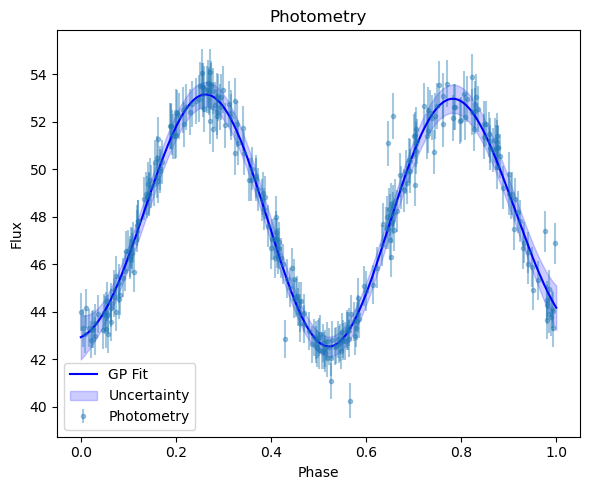

In [282]:
plot_photometry(val_dataset, 135)

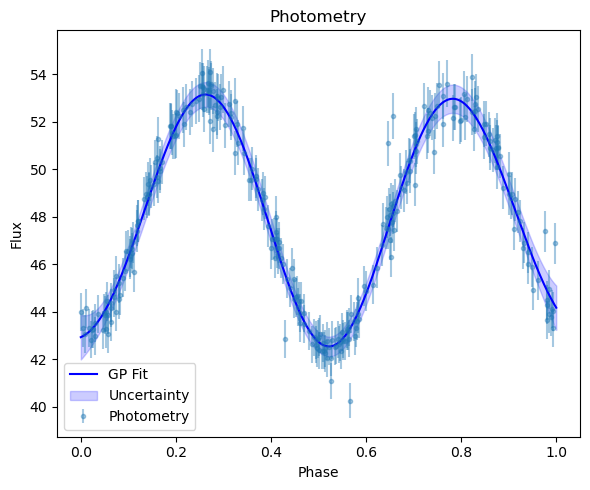

In [278]:
plot_photometry(val_dataset, 135)

In [264]:
idx = 135
dataset = train_dataset

el = dataset.df.iloc[idx]
label = target2id[el['target']]
P = el['org_period']

photometry = dataset.get_vlc(el['name'])
t, flux, flux_err = photometry[:, 0], photometry[:, 1], photometry[:, 2]

mag = -2.5 * np.log10(flux)
dmag = 2.5 / np.log(10) * (flux_err / flux)

mag_median = np.median(mag)
mag = mag / mag_median 

kernel = 1.0 * RBF(length_scale=1.0)    
gp = GaussianProcessRegressor(kernel=kernel, alpha=dmag**2)
gp.fit(t.reshape(-1, 1), mag)

X_test = np.linspace(0, 1, 1000).reshape(-1, 1)
y_pred, y_std = gp.predict(X_test, return_std=True)

y_pred = y_pred * mag_median
y_std = y_std * mag_median

# best_frequency = 1 / P
# t_fit = t.copy()

# ## change nterms to be higher if its an EA
# ls = LombScargle(t, mag, dmag, nterms=8)
# y_fit = ls.model(t_fit, best_frequency)

phased = (t % P) / P
phased_i = np.argsort(phased)

ph = phased[phased_i]
mag = mag[phased_i]
dmag = dmag[phased_i]
mag_fit = y_fit[phased_i]

/global/home/users/mariia/miniforge3/envs/astro/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


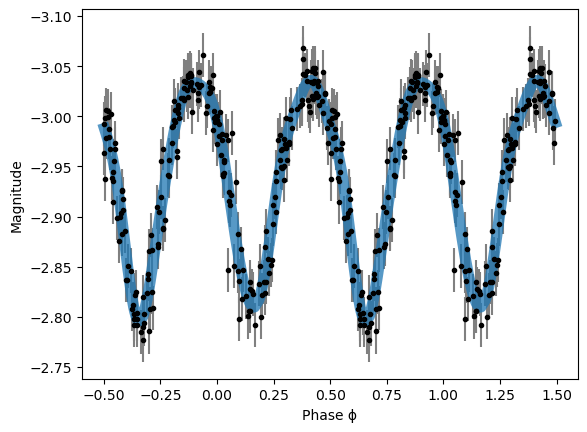

In [258]:
typical_error = np.median(dmag)
ymax = np.max(y_fit) + 4*typical_error
ymin = np.min(y_fit) - 4*typical_error

fig, ax = plt.subplots()

ax.errorbar(list(ph - 0.5) + list(ph + 0.5), list(mag) * 2, list(dmag) * 2, fmt='.k', ecolor='gray')
ax.plot(list(ph - 0.5) + list(ph + 0.5), list(mag_fit) * 2, linewidth=8, alpha=0.75)

ax.set(xlabel='Phase ϕ', ylabel='Magnitude')
# ax.set_xlim(-0.5,1.5)
# ax.set_ylim(ymax,ymin)
ax.invert_yaxis()

<ErrorbarContainer object of 3 artists>

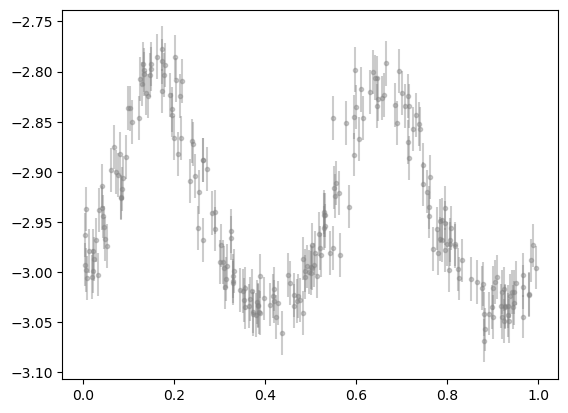

In [254]:
plt.errorbar(ph, mag, yerr=dmag, fmt='.', label='Photometry', alpha=0.4, color='gray')

In [209]:
len(train_dataset.df)

8526

In [208]:
train_dataset.df.iloc[139]['id']

'EDR3 3381765512666147712'

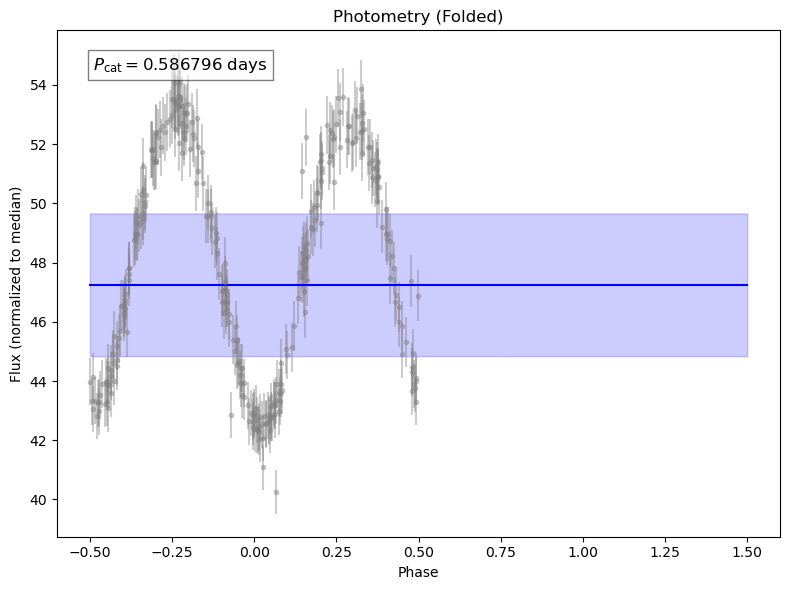

In [240]:
plot_photometry(val_dataset, 135)

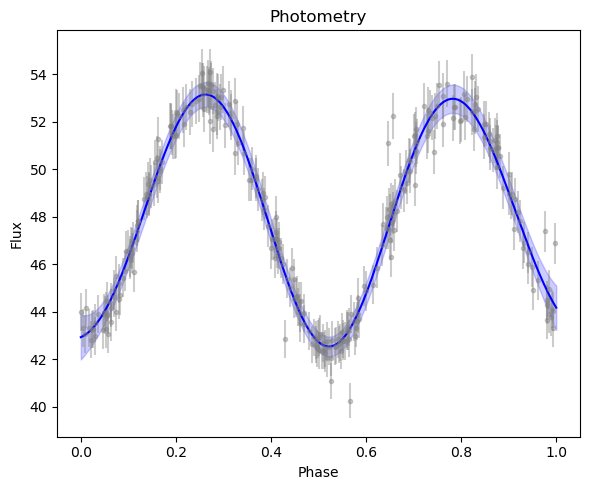

In [205]:
plot_photometry(val_dataset, 135)

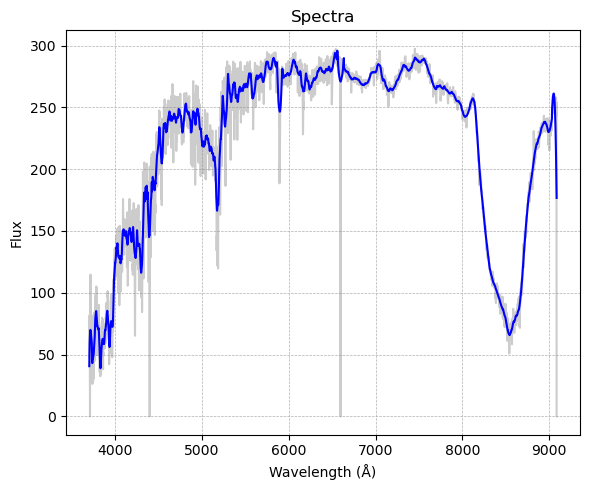

In [220]:
plot_spectra(test_dataset, 120)

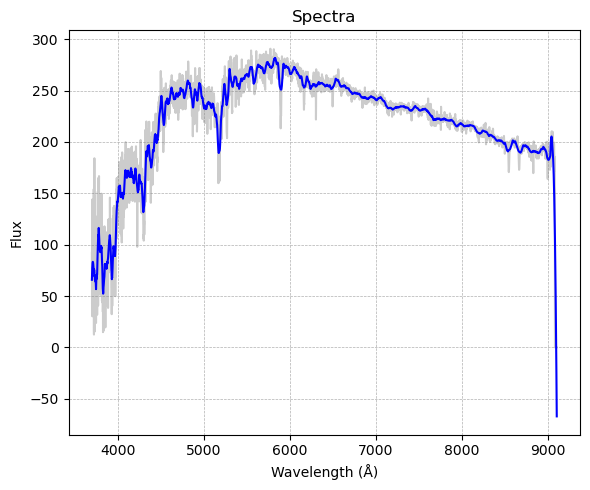

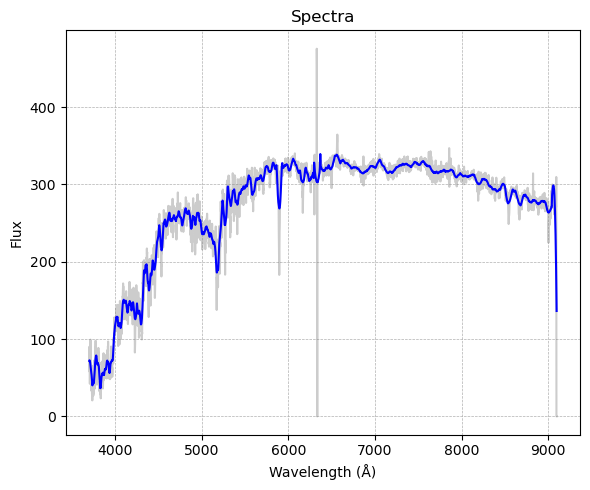

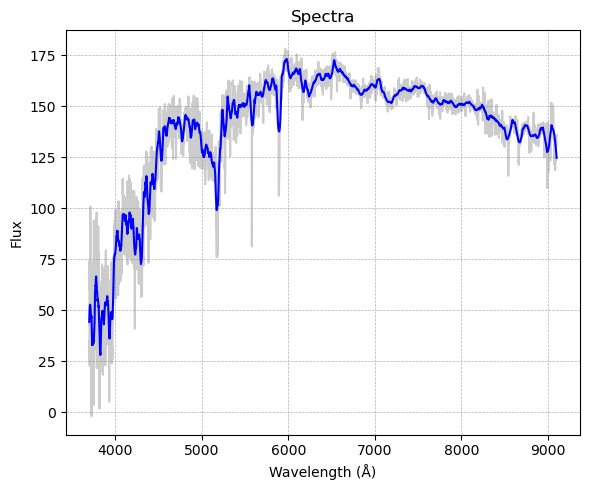

In [218]:
plot_spectra(train_dataset, 2128)
plot_spectra(train_dataset, 1508)
plot_spectra(train_dataset, 8386)

/global/home/users/mariia/miniforge3/envs/astro/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


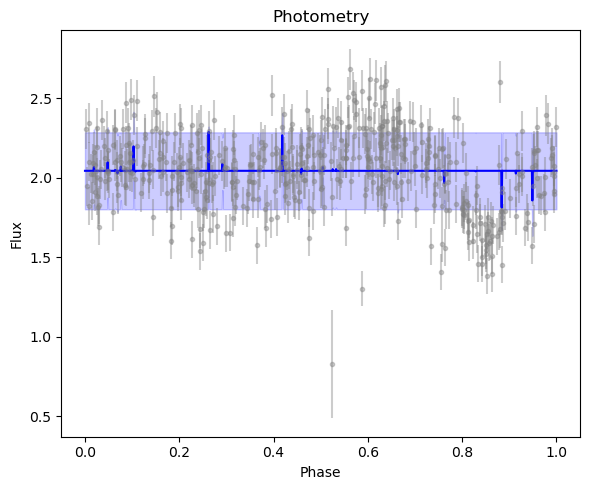

In [214]:
plot_photometry(test_dataset, 120)

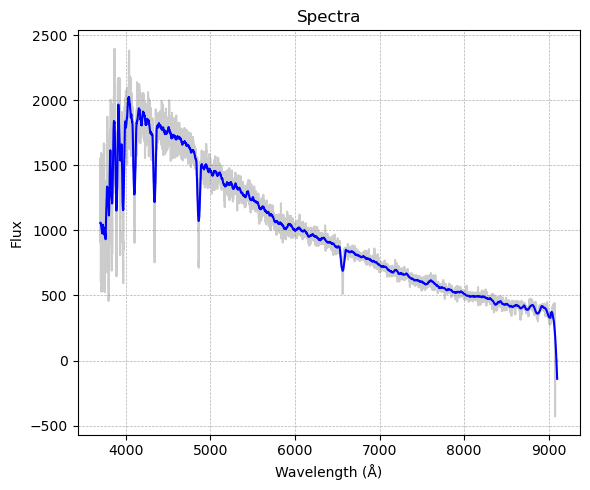

In [204]:
plot_spectra(val_dataset, 135)

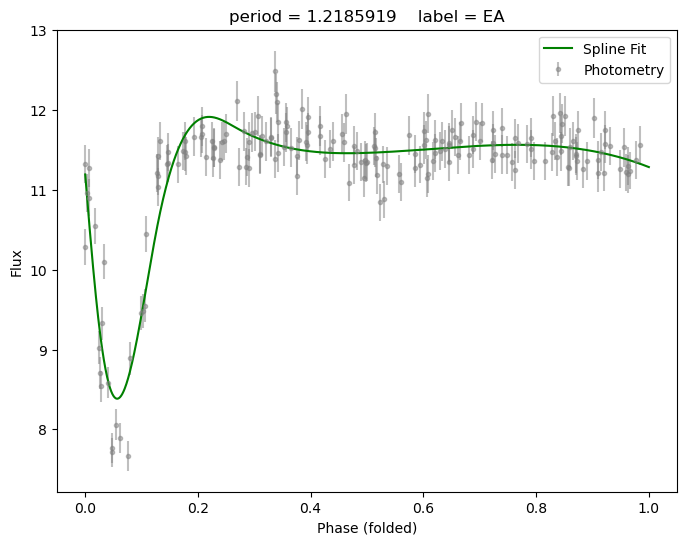

In [181]:
plot_photometry3(train_dataset, 3)

In [25]:
run_id = 'MeriDK/AstroCLIPResults3/2wz4ysvn'
api = wandb.Api()
run = api.run(run_id)

config = run.config
config['use_wandb'] = False
config['file'] = 'preprocessed_data/sub50_lb/spectra_and_v'

test_dataset = PSMDataset(config, split='test')
val_dataset = PSMDataset(config, split='val')
train_dataset = PSMDataset(config, split='train')

class_freq = test_dataset.df['target'].value_counts()
sorted_classes = class_freq.index

id2target = test_dataset.id2target
target2id = test_dataset.target2id

In [22]:
test_idx = joblib.load('test_idx.pkl')
val_idx = joblib.load('val_idx.pkl')
train_idx = joblib.load('train_idx.pkl')

/global/home/users/mariia/miniforge3/envs/astro/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO

In [21]:
test_idx

tensor([  58,   60,   71,   72,   83,  120,  151,  209,  238,  244,  264,  272,
         284,  286,  295,  325,  330,  379,  464,  477,  489,  502,  511,  531,
         563,  573,  596,  666,  674,  679,  689,  692,  738,  745,  781,  792,
         863,  877,  900,  928,  981, 1081, 1110])

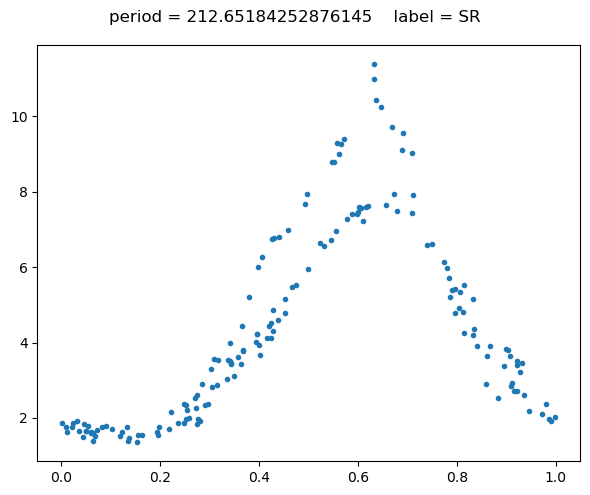

In [55]:
plot_photometry(train_dataset, 139, period=212.65184252876145)

In [113]:
def plot_wrong_period(ds, idx):
    photometry = ds.get_vlc(ds.df.iloc[idx]['name'])
    period = ds.df.iloc[idx]['org_period']

    time = photometry[:, 0]
    flux = photometry[:, 1]
    flux_err = photometry[:, 2]
    
    t, y, yerr, rez, P, mean_flux_mag, mean_flux_mag_err, mag0 = clip_outliers(time, flux, flux_err)
    photometry1 = np.vstack(((time % period) / period, flux, flux_err)).T    # fold
    photometry2 = np.vstack(((time % P) / P, flux, flux_err)).T    # fold

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(photometry1[:, 0], photometry1[:, 1], '.')
    axes[0].set_title(f'period = {period}')
    axes[1].plot(photometry2[:, 0], photometry2[:, 1], '.')
    axes[1].set_title(f'period = {P}')
    
    plt.tight_layout()
    plt.show()

In [183]:
train_dataset.df.iloc[4396]

mean_vmag                                                   -1.600342
amplitude                                                   -0.337755
period                                                      -0.345456
phot_g_mean_mag                                              -1.62895
e_phot_g_mean_mag                                           -0.376928
lksl_statistic                                               1.357988
rfr_score                                                    -1.42182
phot_bp_mean_mag                                            -1.565797
e_phot_bp_mean_mag                                          -0.113929
phot_rp_mean_mag                                             -1.68392
e_phot_rp_mean_mag                                          -0.469465
bp_rp                                                        0.963241
parallax                                                    -0.440679
parallax_error                                              -0.397891
parallax_over_error 

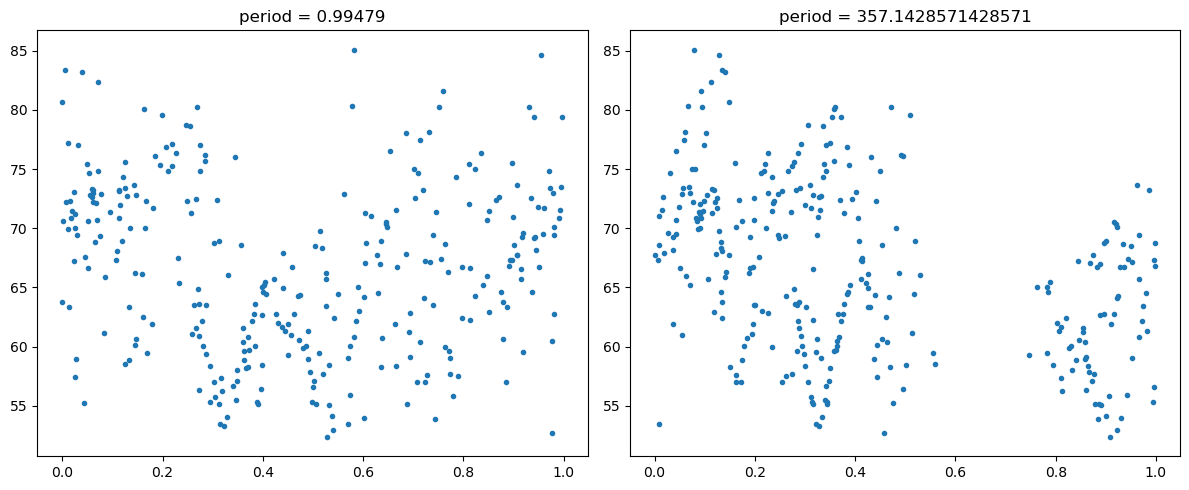

In [182]:
plot_wrong_period(train_dataset, 4396)

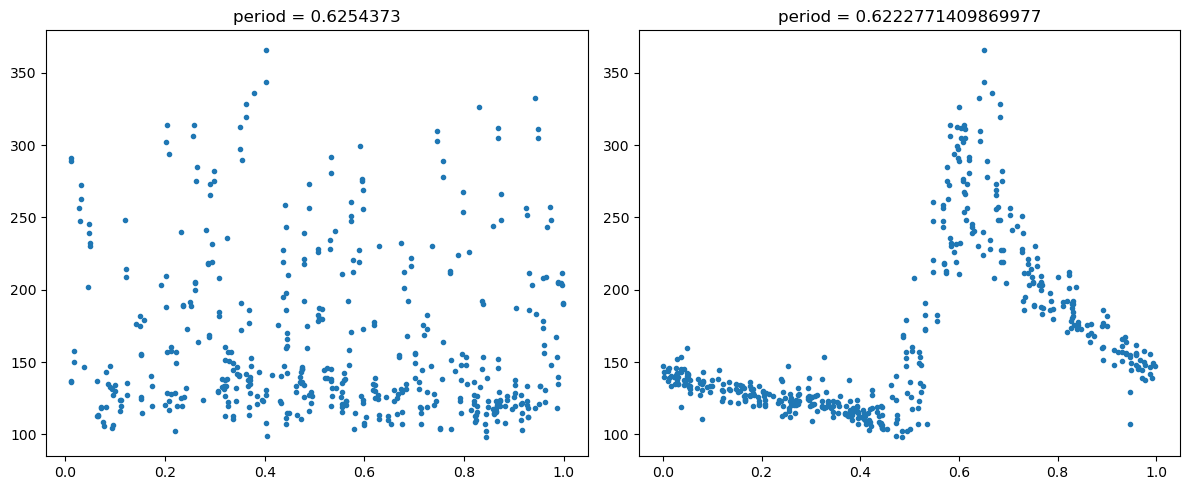

In [114]:
plot_wrong_period(val_dataset, 114)

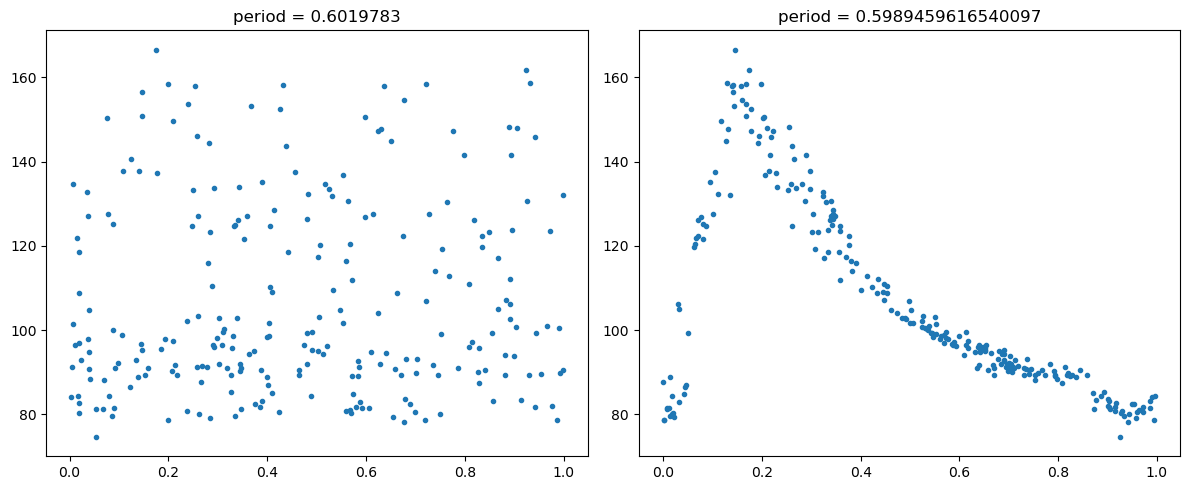

In [115]:
plot_wrong_period(val_dataset, 118)

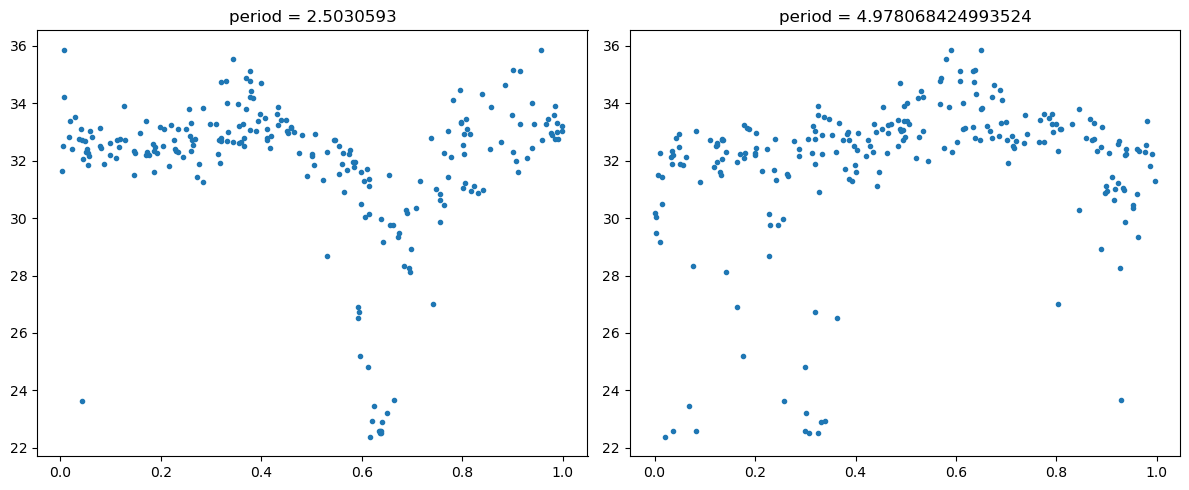

In [116]:
plot_wrong_period(val_dataset, 597)

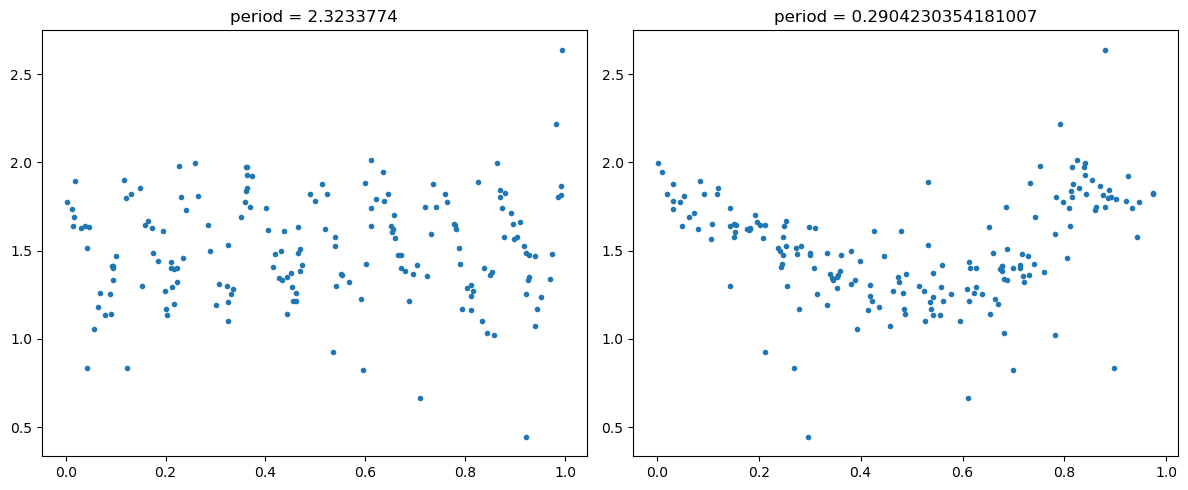

In [117]:
plot_wrong_period(train_dataset, 510)

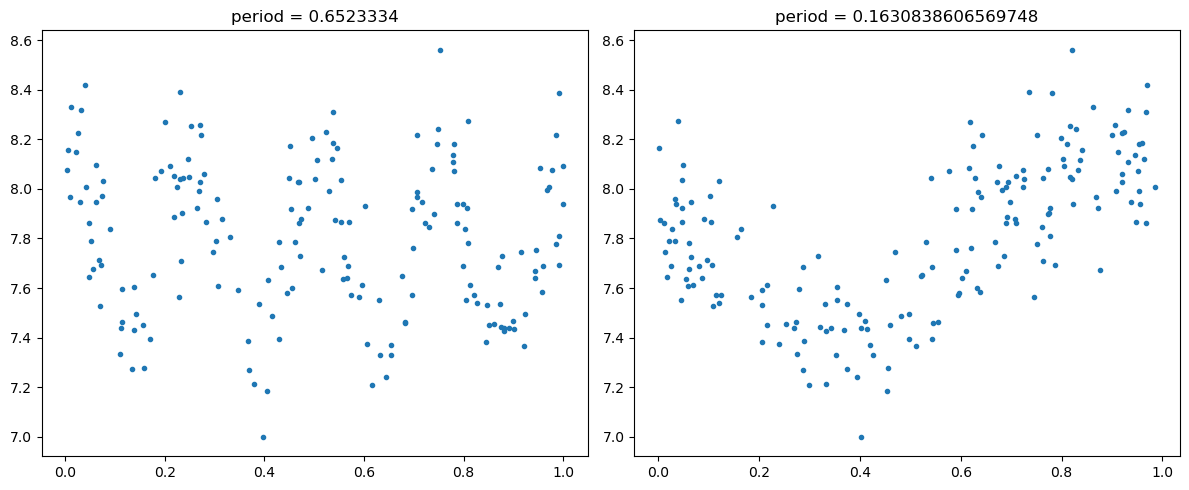

In [118]:
plot_wrong_period(train_dataset, 446)

/global/home/users/mariia/AstroML/notebooks/../util/preprocess_data.py:173: RuntimeWarning: invalid value encountered in log10
  rez["freq_fits"][0]["model"] = mag0 - 2.5*np.log10(


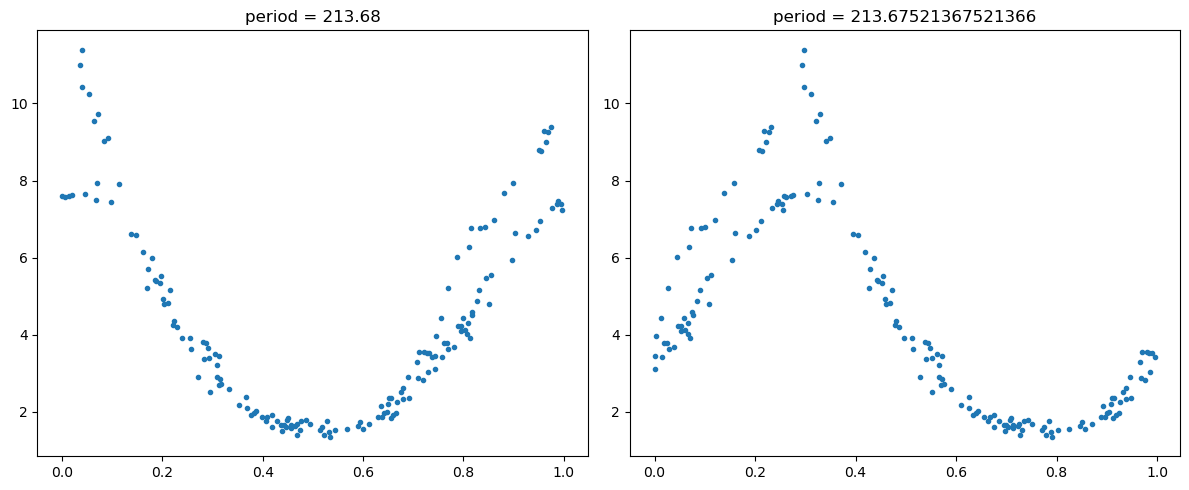

In [119]:
plot_wrong_period(train_dataset, 139)

In [93]:
P

4.978068424993524

In [94]:
frequency, power = LombScargle(time, flux).autopower()
best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency
print(best_period)

4.909708896693565


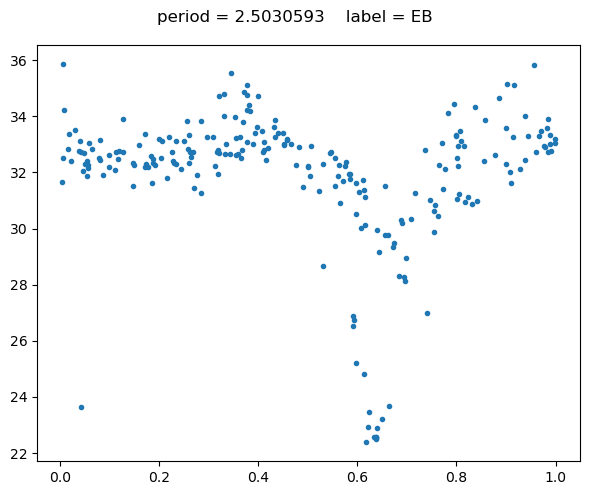

In [90]:
plot_photometry(val_dataset, 597)

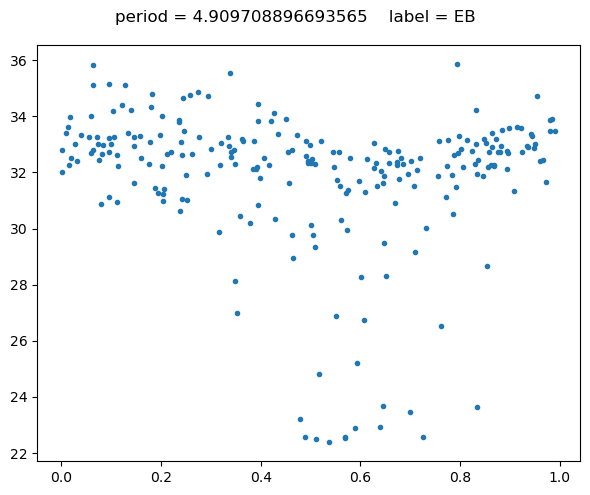

In [96]:
plot_photometry(val_dataset, 597, period=best_period)

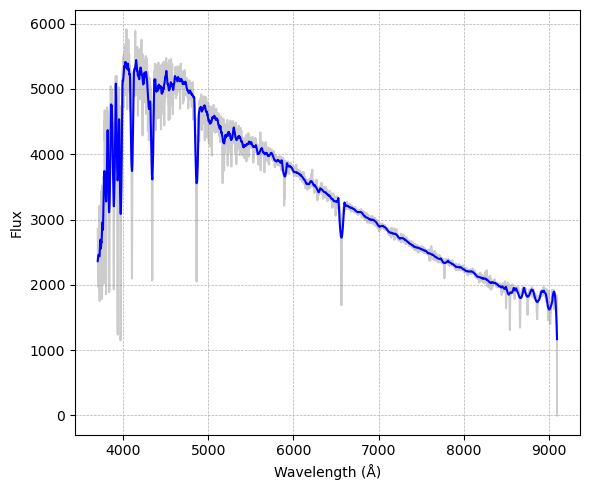

In [74]:
plot_spectra(test_dataset, 114)

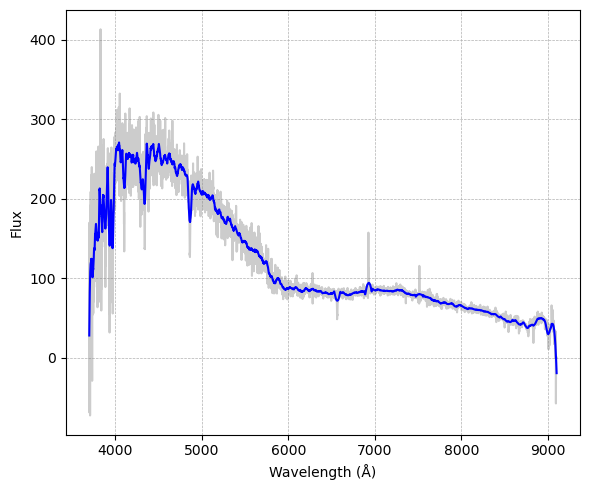

In [120]:
plot_spectra(train_dataset, 403)

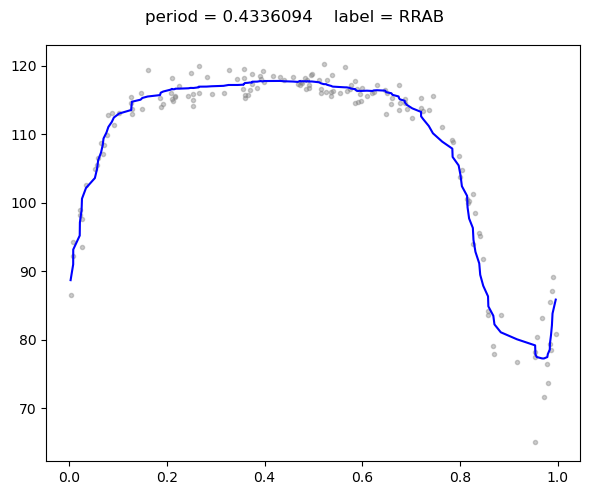

In [161]:
plot_photometry3(train_dataset, 403)

/global/home/users/mariia/miniforge3/envs/astro/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/global/home/users/mariia/miniforge3/envs/astro/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


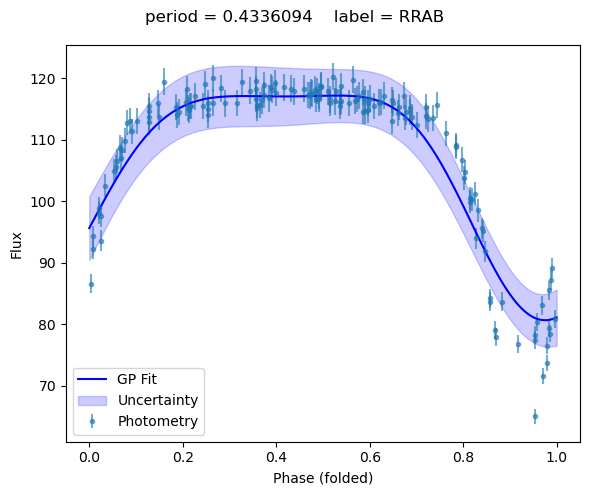

In [149]:
kernel = 1.0 * ExpSineSquared(length_scale=0.5, periodicity=0.4336094) + 1.0 * Matern(length_scale=0.5, nu=1.5) + WhiteKernel(noise_level=0.1)
plot_photometry2(train_dataset, 403, kernel=kernel)

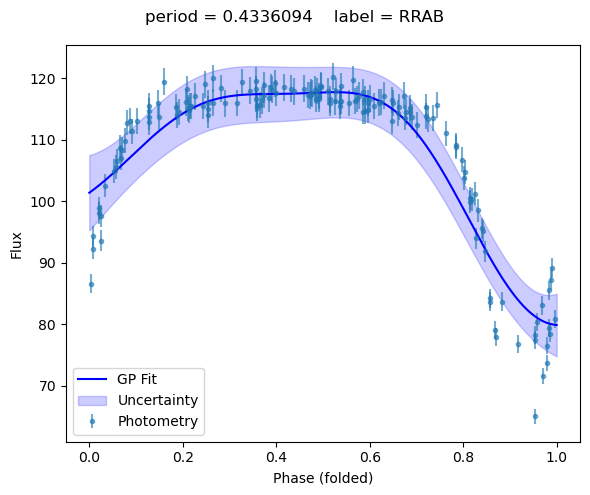

In [131]:
plot_photometry2(train_dataset, 403, length_scale=1.0)

In [210]:
df1 = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_test.csv')
df2 = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_train.csv')
df3 = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_val.csv')

In [212]:
len(df1) + len(df2) + len(df3)

21750

In [42]:
df_org = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full_lb/spectra_and_v_test.csv')

In [46]:
df_org.iloc[243]

mean_vmag                                                       15.73
amplitude                                                        0.45
period                                                       0.383351
phot_g_mean_mag                                             15.319804
e_phot_g_mean_mag                                            0.004551
lksl_statistic                                                   0.59
rfr_score                                                        0.68
phot_bp_mean_mag                                            15.888126
e_phot_bp_mean_mag                                           0.014277
phot_rp_mean_mag                                            14.558028
e_phot_rp_mean_mag                                           0.010065
bp_rp                                                        1.330098
parallax                                                       1.8018
parallax_error                                                 0.0279
parallax_over_error 

In [41]:
test_dataset.df.iloc[120]

mean_vmag                                                    1.822404
amplitude                                                   -0.080925
period                                                      -0.735583
phot_g_mean_mag                                               1.65485
e_phot_g_mean_mag                                           -0.499512
lksl_statistic                                               0.952875
rfr_score                                                   -1.132625
phot_bp_mean_mag                                             1.790759
e_phot_bp_mean_mag                                          -0.315967
phot_rp_mean_mag                                             1.538431
e_phot_rp_mean_mag                                           -0.51058
bp_rp                                                       -0.089744
parallax                                                     0.580568
parallax_error                                              -0.172781
parallax_over_error 

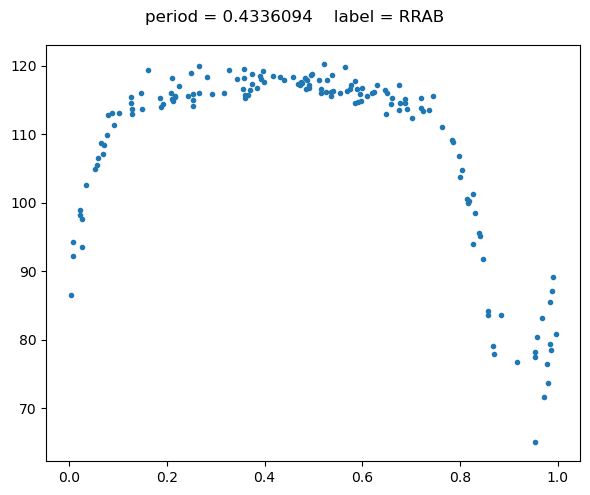

In [32]:
plot_photometry(train_dataset, 403)

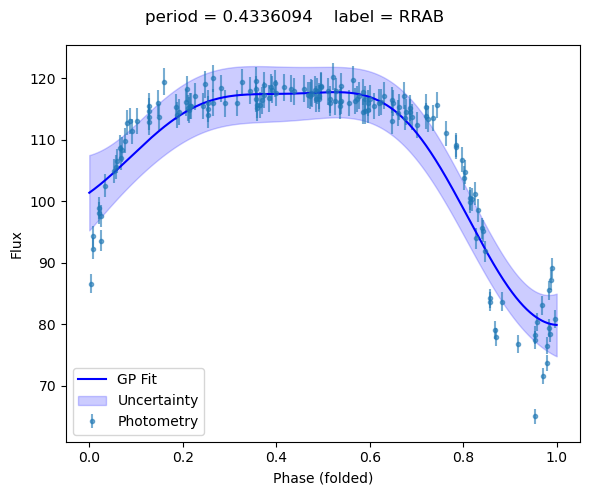

In [36]:
plot_photometry2(train_dataset, 403)

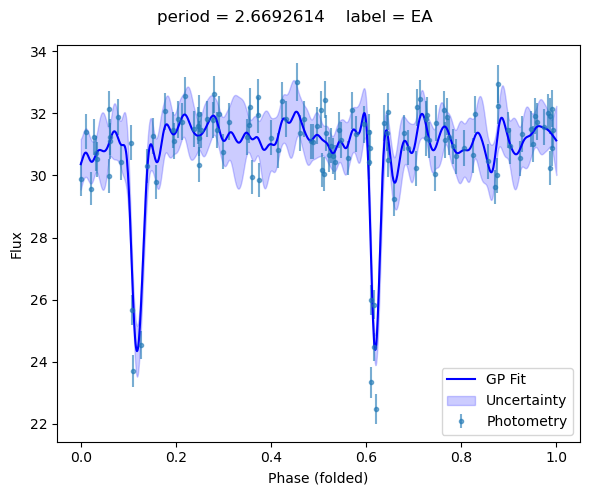

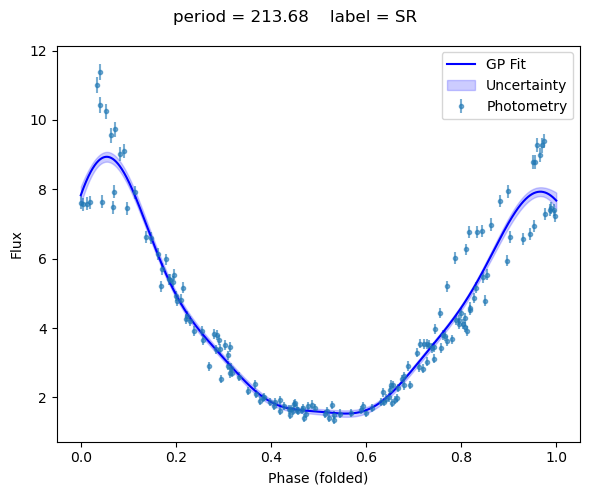

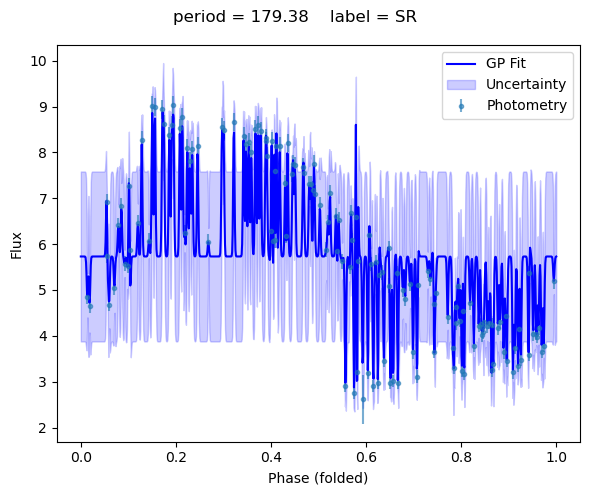

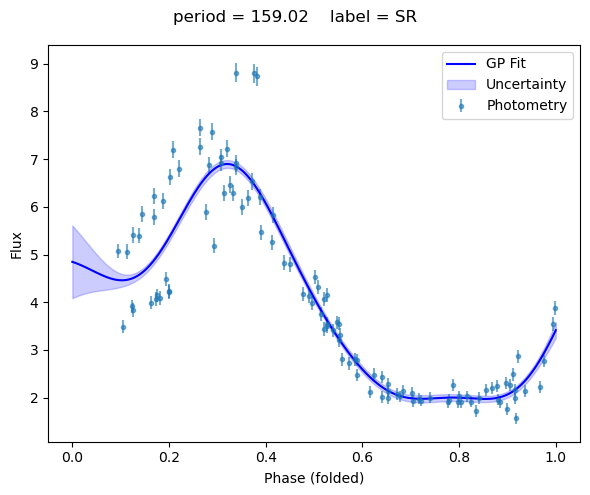

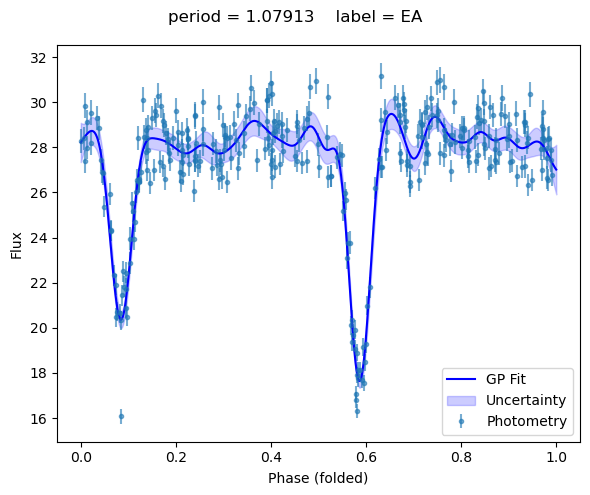

In [38]:
for i in range(5):
    plot_photometry2(train_dataset, train_idx[i].item())

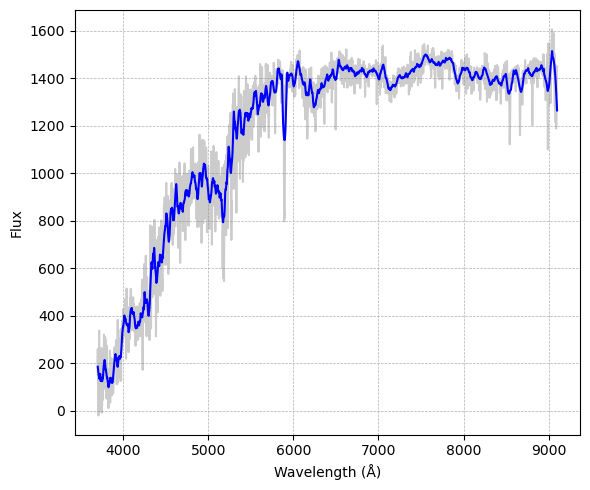

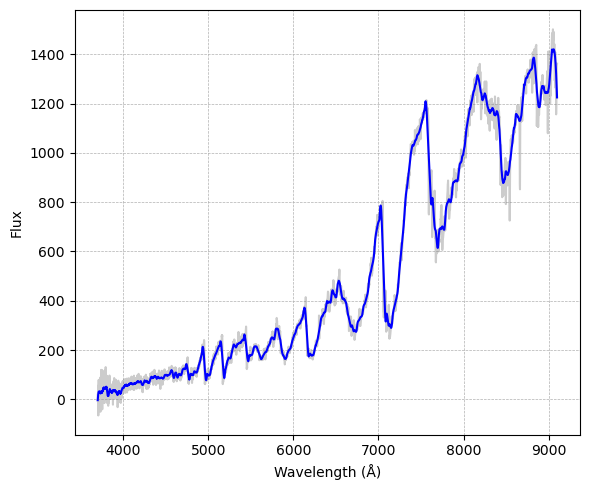

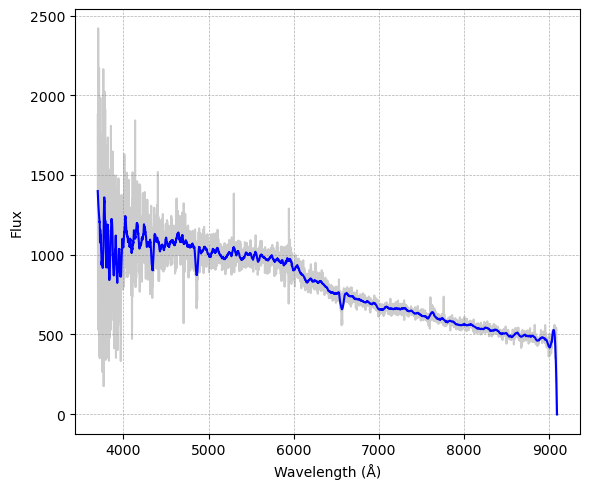

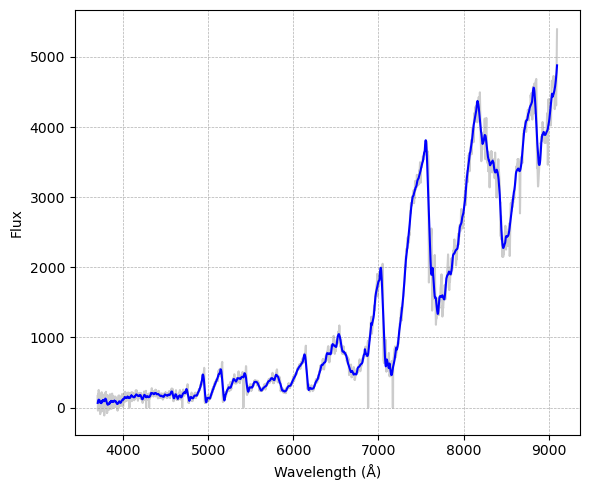

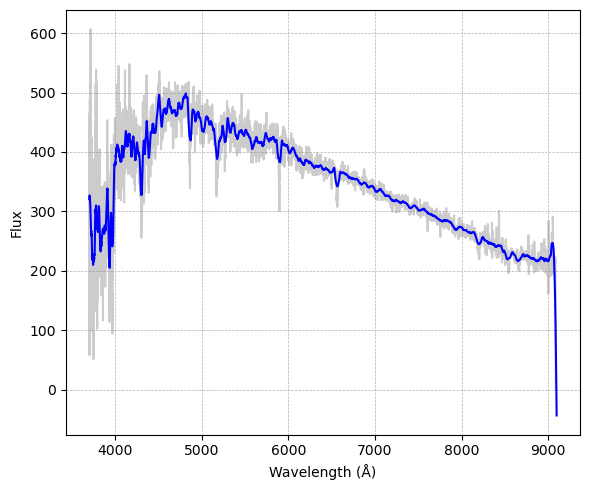

In [14]:
for i in range(5):
    plot_spectra(test_dataset, test_idx[i].item())